In [14]:
import numpy as np
from numpy import unravel_index
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import random
from scipy.optimize import least_squares
import sys
from scipy.optimize import curve_fit
import statistics
import npyscreen



# Parameters

In [15]:
A_min = 1e3 # Bq
A_max = 2e3 # Bq
A_b = 5e-5 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 100; sigma_x = 0.1 # m
y_max = 100; sigma_y = 0.1 # m
grid = 8
n_bins = 20
K = 0.1 # is somewhere in the interval [0, 1]
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq

n_points = 50 # fot the random_flyover() -> number of random points generated OR for improv_flyover() -> number of points in a spiral
max_phi = 6*np.pi # rotation in radians that the detector will make will moving in a spiral trajectory
s_grid = 10

radiation = {"A_min": A_min, "A_max": A_max, "A_b": A_b, "dose_factor": F}
detector = {"h": h, "dt": dt, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi, "spiral_grid": s_grid} # the detector constant tells us the quality of the detector



## Subsidariy code

In [16]:
 # it equals to the activity
def activity(source, x, y, h, ru=0, rv=0):
    u, v, A0 = source[0], source[1], source[2] # u, v are the coordinates of the source and A0 is its activity
    return (A0*(ru**2 + rv**2 + h**2)) / ((x - (u - ru))**2 + (y - (v - rv))**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

def dose_speed_xy(source, x, y, radiation, detector):
    A_b = radiation['A_b']
    h = detector['h']; K = detector['detector_constant']; dt = detector['dt']
    
    A = activity(source, x, y, h)
    A_det = A * (1 - K)
    N = np.random.poisson(A_det * dt)
    N_b = np.random.poisson(A_b * dt)# background radiation

    HD = F * (N + N_b)


    dHD = F * np.sqrt(N + N_b)
    return [HD, dHD]

def dose_speed(source, i, j, radiation, detector, grid_x, grid_y):
    A_b = radiation['A_b']
    h = detector['h']; K = detector['detector_constant']; dt = detector['dt']

    x = grid_x[i, j]; y = grid_y[i, j]

    A = activity(source, x, y, h)
    A_det = A * (1 - K)
    N = np.random.poisson(A_det * dt)
    N_b = np.random.poisson(A_b * dt)# background radiation

    HD = F * (N + N_b)

    dHD = F * np.sqrt(N + N_b)
    return [HD, dHD]


## Combination

In [17]:
# combines the detector flyover and the location detection
def combination(radiation, detector, func_fo, func_CF,  source=[], noise=[]):
    h = detector['h']; K = detector['detector_constant']; dt = detector['dt']
    F = radiation['dose_factor']

    measurement = func_fo(radiation, detector, source, noise)
    sourceCF, stDev = func_CF(measurement, detector, noise)[0], func_CF(measurement, detector, noise)[1]
    

    search = 0
    if func_CF == spiral_locationCF:
        search = measurement['search']

    
    alpha = sourceCF[2]; rel_alpha = 1/(sourceCF[2]/stDev[2])
    A0 = (alpha)/(F*(1-K)*dt*h**2)
    dA0 = rel_alpha*A0

    return {'measurement': measurement, 'sourceCF': sourceCF, "sourceCF_stDev": stDev, "A0": [A0, dA0], "search": search}


## ZIG-ZAG flyover

### Flyover

In [18]:

# Noise is a list that contanins the standard deviations of x/y coordinates as a result of the error of the detector
def flyover(radiation, detector, source = [], noise = []):
    A_min = radiation['A_min']; A_max = radiation['A_max']; A_b = radiation['A_b']
    h = detector['h']; dt = detector['dt']; x_max = detector['x_max']; y_max = detector['y_max']; grid = detector['grid']; K = detector['detector_constant']
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid

    grid_x, grid_y = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    
    # If the source is not specified, then it is randomly generated 
    if len(source) == 0: 
        source = point_source(x_max, y_max, A_min, A_max)
    
    HDs = np.zeros((int(N_grid), int(N_grid))); dHDs = np.zeros((int(N_grid), int(N_grid)))
    n, m = N_grid - 1, 0
    y = -y_max + square_y/2
    i = 1
    for x in xs:
        while abs(y) <= y_max:
            A = activity(source, x, y, h)
            A_det = A * (1 - K)
            N = np.random.poisson(A_det * dt)
            N_b = np.random.poisson(A_b * dt)# background radiation

            # Add noise to the location data because of the GPS uncertianty
            if len(noise) != 0:
                sigma_x = noise[0]; sigma_y = noise[1]
                grid_x_noise[n, m] = x + np.random.normal(0, sigma_x)
                grid_y_noise[n, m] = y + np.random.normal(0, sigma_y)

            HDs[n, m] = F * (N + N_b)
            dHDs[n, m] = F * np.sqrt(N + N_b)
            
            grid_x[n, m] = x; grid_y[n, m] = y
            y += (square_y)*i
            n -= 1*i
        n += 1*i; i = i * (-1); y += (square_y)*i; m += 1
    i_max, j_max = unravel_index(HDs.argmax(), HDs.shape)
    x_c, y_c = grid_x[i_max, j_max], grid_y[i_max, j_max]
    maxI_range = {"xrange": (x_c - square_x/2, x_c + square_x/2), "yrange": (y_c - square_x/2, y_c + square_x/2)}

    return {"m_dose": HDs, "dm_dose": dHDs, "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "hotspot": maxI_range, "square_x": square_x, "square_y": square_y, "x_max": x_max, "y_max": y_max}

measurement = flyover(radiation, detector)


### Location from flyover

#### Scipy least squares

In [19]:
# Using the Levenberg-Marquardt method with scipy least squares
def locationLM(measurement, radiation, detector):
    A_min, A_max = radiation['A_min'], radiation['A_max']
    h = detector['h']
    hotspot = measurement['hotspot']
    x_0, x_1 = hotspot['xrange']; y_0, y_1 = hotspot['yrange']

    def dose(source, x, y):
        u, v, alpha = source[0], source[1], source[2]
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    # def N(source, x, y):
    #     return N_func(source, x, y, h, dt)

    grid_x, grid_y = measurement['grid_x'], measurement['grid_y']
    HDs = measurement['m_dose']

    def fun(source):
        return (dose(source, grid_x, grid_y) - HDs).flatten()

    # guess = point_source(x_0, y_0, A_min, A_max, x_1, y_1)
    source0 = [1, 1, 1]
    res = least_squares(fun, source0, method="lm")

    return res["x"]

measurement = flyover(radiation, detector)
sourceLM = locationLM(measurement, radiation, detector)

#### Scipy curve fit

In [20]:
# Also location with LM method, only now using the curve_fit scipy.optimize function 
def locationCF(measurement, detector, noise = []):
    HDs, dHDs, grid_x, grid_y, hotspot = measurement['m_dose'], measurement['dm_dose'], measurement['grid_x'], measurement['grid_y'], measurement["hotspot"] # in example Z, here Is
    grid_x_noise = measurement['grid_x_noise']; grid_y_noise = measurement['grid_y_noise']
    h = detector["h"]

    x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]

    if len(noise) == 0:
        XY = np.vstack((grid_x.ravel(), grid_y.ravel()))
    else:
        XY = np.vstack((grid_x_noise.ravel(), grid_y_noise.ravel()))
        
    source0 = [random.uniform(x_0, x_1), random.uniform(y_0, y_1), 1]
    
    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs.ravel(), source0, sigma = dHDs.ravel(), absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict


sourceCF = locationCF(measurement, detector)

### Visualization

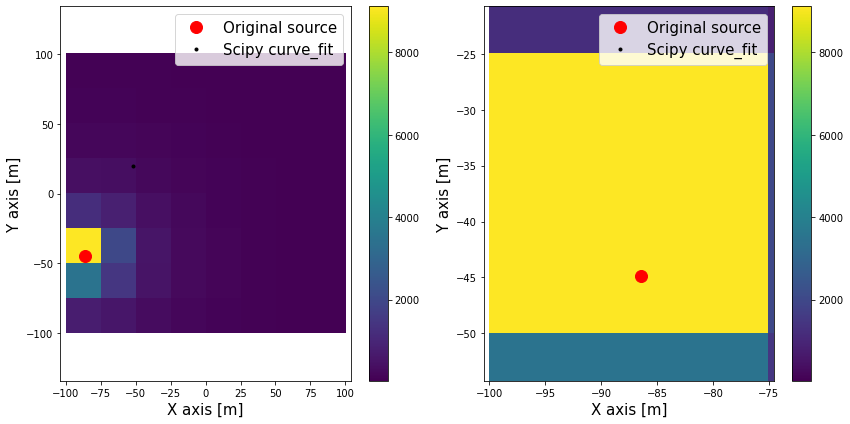

In [21]:
def visualize(data):
    measurement = data['measurement']
    x_max = measurement['x_max']; y_max = measurement['y_max']
    original = measurement['source']
    estimate = data['sourceCF']

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im0 = ax1.imshow(measurement['m_dose'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    if original != []:
        ax1.plot(original[0], original[1], "o", color = 'r', ms=12, label = "Original source")
    ax1.plot(estimate[0], estimate[1], "o", color = 'k', ms=3, label = "Scipy curve_fit")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    hotspot = measurement['hotspot']
    x_0, x_1 = hotspot['xrange']; y_0, y_1 = hotspot['yrange']

    im1 = ax2.imshow(measurement['m_dose'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    if original != []:
        ax2.plot(original[0], original[1], "o", color = 'r', ms=12, label = "Original source")
    # ax2.plot(u1, v1, "o", color = 'g', ms=6, label = "Scipy least_square")
    ax2.plot(estimate[0], estimate[1], "o", color = 'k', ms=3, label = "Scipy curve_fit")
    ax2.axis("equal")
    ax2.set_xlim(x_0, x_1)
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(y_0, y_1)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)    

    fig.colorbar(im0, ax=ax1)
    fig.colorbar(im1, ax=ax2)

    plt.tight_layout()
    plt.show()

data = combination(radiation, detector, flyover, locationCF, [], [])
visualize(data)


## Random flyover

### Flyover

In [22]:
# Noise is a list that contanins the standard deviations of x/y coordinates as a result of the error of the detector
def random_flyover(radiation, detector, source = [], noise = []):
    A_min = radiation['A_min']; A_max = radiation['A_max']; A_b = radiation['A_b']; F = radiation['dose_factor']
    h = detector['h']; dt = detector['dt']; x_max = detector['x_max']; y_max = detector['y_max']; N_grid = detector['grid']; K = detector['detector_constant']
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    grid_x, grid_y = np.meshgrid(xs, np.flip(ys))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))

    # If the source is not specified, then it is randomly generated 
    if len(source) == 0: 
        source = point_source(x_max, y_max, A_min, A_max)
    i = 0
    points = np.zeros((1, 4))
    while i < n_points:
        x = random.uniform(-x_max, x_max); y = random.uniform(-y_max, y_max)

        # Simulate the number of events acoording to the Poisson distribution and add noise

        A = activity(source, x, y, h)
        A_det = A * (1 - K)
        N = np.random.poisson(A_det * dt)
        N_b = np.random.poisson(A_b * dt)# background radiation

        # Add noise to the location data because of the GPS uncertianty

        if len(noise) != 0:
            sigma_x = noise[0]; sigma_y = noise[1]
            x += np.random.normal(0, sigma_x)
            y += np.random.normal(0, sigma_y)

        HD = F * (N + N_b); dHD = F * np.sqrt(N + N_b)
        row = np.array([x, y, HD, dHD])
        points = np.vstack((points, row))          
        i += 1

    return {"points": points[1:, :], "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "square_x": square_x, "square_y": square_y}

rand_measurement = random_flyover(radiation, detector)
# print(rand_measurement)


### Location from measurement

In [23]:
# Fit

def random_locationCF(measurement, detector, noise=[]):
    points = measurement['points']
    h, x_max, y_max = detector['h'], detector['x_max'], detector['y_max']

    XY = np.vstack((points[:, 0], points[:, 1]))
    HDs = points[:, 2]
    dHDs = points[:, 3]

    source0 = [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), 1]

    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs, source0, sigma = dHDs, absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict


### Visualization

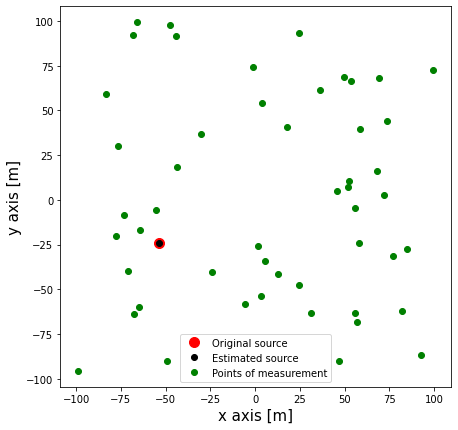

In [24]:
# Visualization

def random_visualize(data):

    fig, ax = plt.subplots(figsize = (7, 7))

    original = data['measurement']['source']
    estimate = data['sourceCF']
    measured = data['measurement']['points']

    ax.plot(original[0], original[1], "o", c="r", ms=10, label = "Original source")
    ax.plot(estimate[0], estimate[1], "o", c="k", ms=6, label = "Estimated source")
    ax.plot(measured[:, 0], measured[:, 1], "o", c="g", label = "Points of measurement")

    ax.set_xlabel('x axis [m]', fontsize=15)
    # plt.xticks(fontsize=14)
    ax.set_ylabel('y axis [m]', fontsize=15)
    # plt.yticks(fontsize=14)
    
    ax.axis("equal")
    plt.legend()
    plt.show()

data_random = combination(radiation, detector, random_flyover, random_locationCF, [], [])
random_visualize(data_random)


## Spiral flyover

The idea is to first locate the "hotspot" tile and then make measurements as the detector flys in a spiral outward from the centre of the hotspot tile

### Flyover

In [25]:
def make_list(source, i, j, radiation, detector, grid_x, grid_y):
    N_grid = detector['spiral_grid']
    HDs = []; direction = []
    if j != (N_grid - 1): # go right
        HDs0 = dose_speed(source, i, j + 1, radiation, detector, grid_x, grid_y)
        HDs.append(HDs0[0])
        direction.append(0)
    if (i != (N_grid - 1)) and (j != (N_grid - 1)): # go diagonally
        HDs1 = dose_speed(source, i + 1, j + 1, radiation, detector, grid_x, grid_y)
        HDs.append(HDs1[0])
        direction.append(1)
    if i != (N_grid - 1): # go left
        HDs2 = dose_speed(source, i + 1, j, radiation, detector, grid_x, grid_y)
        HDs.append(HDs2[0])
        direction.append(2)
    if len(HDs) != 0:
        max_HD = max(HDs)
        max_id = HDs.index(max_HD)
        d = direction[max_id]
        return {"direction": d, "max_doseSpeed": max_HD, "mes": len(HDs)}

def r_ArhSpir(phi, k=1):
    return k * phi

def spiral_flyover(radiation, detector, source = [], noise = []):
    A_min = radiation['A_min']; A_max = radiation['A_max']
    h = detector['h']; x_max = detector['x_max']; y_max = detector['y_max']; N_grid = detector['spiral_grid']
    n_points = detector['n_points']; max_phi = detector['max_phi']
    dx, dy = (2*x_max)/N_grid, (2*y_max)/N_grid
    
    # grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + dx/2, x_max - dx/2, int(N_grid))
    ys = np.flip(np.linspace(-y_max + dy/2, y_max - dy/2, int(N_grid)))
    grid_x, grid_y = np.meshgrid(xs, ys)
    # grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    map = np.zeros((N_grid, N_grid))
    
    if len(source) == 0:
        source = point_source(x_max, y_max, A_min, A_max)


    i, j = 0, 0
    search = 0
    HD_max = 0
    HD = dose_speed(source, i, j, radiation, detector, grid_x, grid_y)[0]
    while (HD < HD_max) or (i == 0 and j == 0):
            search += 1
            if (i == (N_grid - 1)) and (j == (N_grid - 1)):
                break
            map[i, j] = HD
            dictionary = make_list(source, i, j, radiation, detector, grid_x, grid_y)
            d = dictionary['direction']; HD_max = dictionary['max_doseSpeed']
            if d == 0: # go right
                j += 1
            elif d == 1: # go diagonally
                i +=1; j += 1
            else: # go down
                i += 1
            HD = HD_max
            if (i != (N_grid - 1)) and (j != (N_grid - 1)):
                dicT = make_list(source, i, j, radiation, detector, grid_x, grid_y)
                HD_max = dicT['max_doseSpeed']
                search += dicT['mes']
            else:
                break
    map[i, j] = HD
    x_h = grid_x[i, j]; y_h = grid_y[i, j]
    phis = np.linspace(0, max_phi, n_points)
    if x_max <= y_max:#dx <= dy:
        k = x_max / (max_phi * np.cos(max_phi))
        #k = ((3*dx)/(2*max_phi))
    else:
        k = y_max / (max_phi * np.sin(max_phi))
        #k = ((2*dy)/(2*max_phi))
    x_data = []; y_data = []
    HDs = []; dHDs = []
    for phi in phis:
        r = r_ArhSpir(phi, k)
        x_data.append(r*np.cos(phi) + x_h)
        y_data.append(r*np.sin(phi) + y_h)
        List = dose_speed_xy(source, x_data[-1], y_data[-1], radiation, detector)
        HDs.append(List[0]); dHDs.append(List[1])

    return {"m_dose": np.array(HDs), "dm_dose": dHDs, "maps": map, "source": source, "x_max": x_max, "y_max": y_max, "hotspot": [x_h, y_h], "x_data": np.array(x_data), "y_data": np.array(y_data), "search": search}

problematic_source0 = [87.27186149650258, -96.62443338613733, 1327.4757423574104]
problematic_source1 = [-71.17426436785817, -87.664478745402, 1000]
measurement = spiral_flyover(radiation, detector)
# measurement


### Source location

In [26]:
# fit
def spiral_locationCF(measurement, detector, noise = []):
    x_data = measurement['x_data']
    y_data = measurement['y_data']
    h, x_max, y_max = detector['h'], detector['x_max'], detector['y_max']

    XY = np.vstack((x_data, y_data))
    HDs = measurement['m_dose']
    dHDs = measurement['dm_dose']

    source0 = [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), 1]

    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs, source0, sigma = dHDs, absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict

# location = spiral_locationCF(measurement, detector)


### Visualization

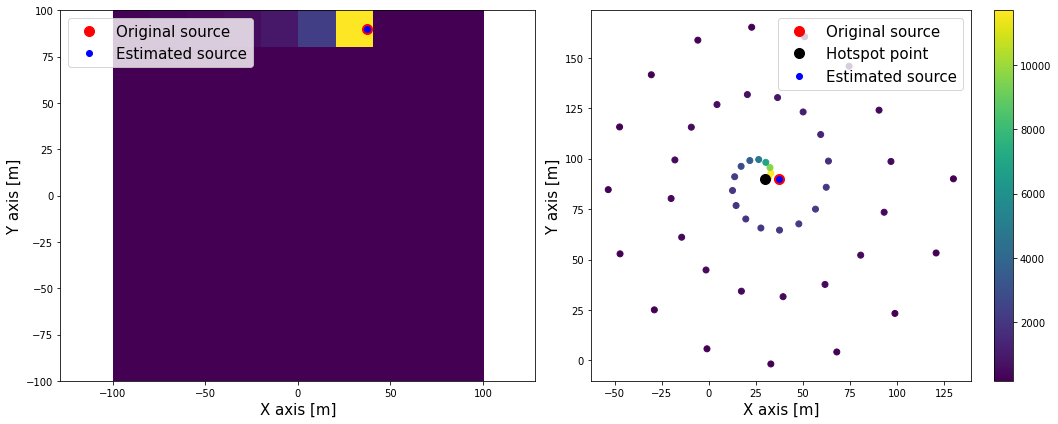

In [27]:
def spiral_visualize(data):


    measurement = data['measurement']
    estimate = data['sourceCF']

    X, Y = measurement['source'][0], measurement['source'][1]
    x_max, y_max = measurement['x_max'], measurement['y_max']
    HDs = measurement['m_dose']

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
    
    im1 = ax1.imshow(measurement['maps'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax1.plot(X, Y, "o", color = 'r', ms=10, label = "Original source")
    ax1.plot(estimate[0], estimate[1], 'o', color = "b", ms = 6, label = "Estimated source")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    x_h, y_h = measurement['hotspot'][0], measurement['hotspot'][1]
    x_data = measurement['x_data']; y_data = measurement['y_data']

    # im2 = ax2.imshow(measurement['maps'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax2.plot(X, Y, 'o', color = 'r', ms=10, label = "Original source")
    ax2.plot(x_h, y_h, 'o', color = 'k', ms=10, label = "Hotspot point")
    im0 = ax2.scatter(x_data, y_data, c=HDs)
    ax2.plot(estimate[0], estimate[1], 'o', color = "b", ms = 6, label = "Estimated source")


    # ax2.plot(x_data, y_data, "o", color = "k", label = "Measurements")

    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax2.legend(fontsize = 15)

    fig.colorbar(im0, ax=ax2)

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    
    # return points[1]
    # print(measurement["intensities_array"], '\n', measurement["grid_x"], '\n', measurement["grid_y"])
problematic_source0 = [87.27186149650258, -96.62443338613733, 1327.4757423574104]
far_source = [x_max, -y_max, (A_max + A_min)/2]
source00 = [0, 0, (A_max + A_min)/2]

data = combination(radiation, detector, spiral_flyover, spiral_locationCF)
spiral_visualize(data)

# An error that can occur is if we input to large of a number of grids the difference between the neighbouring tiles might be overshadowed by
# the poisson distribution error of the detector. This will result in the detector stoping before reaching the hotspot tile.


# Code description

## Description

In comparisson to the code in simple_SPS.ipynb there are a few minor changes. The intensity function is now named activity and is defined diferently. It takes into consideration two points, the source of the radiation and the position of a measurement. Flyover() is very similar to the older version it just uses the new activity function and also the activity of the source (A0) is randomly generated - it is one of the parameters which we are fitting.

locationLM() is the major chenge. We use the scipy least square Levenberg-Marquardt method to minimize the square residuals of the model dose speed and the measured dose speed. The model dose speed has a similar function look as the activity function. Measurement of the dose speed is simulated by calculating the activity of the source at a detector position. We then multiply it by (1 - K), where K is the detector constant. This number is then used as the occurance rate in a random Poisson number generation, which gives us the number of events the detector measures. We multiply this with F, the dose factor which is different depending on what source we are looking at. The end result is the simulated measurement of the dose speed. Through the minimization (of the meaured and model doese) we can output the paramaters which we are searching for - u, v (x/y coordinates of the source) and a constant from which we could extract the information of the activity of the source.

visualize() shows us that this method is much more accurate then the previously used location searching method.

For now two seperate codes where the core principle is the same: make measurements with a detector, fit data to the source and than combine
these two to visualize the final result. The main diference is that in ZIG-ZAG example the detector flies over in a up and down (zig-zag) pattern along the area of measurement. But in the random flyover the measurement points are picked randomly.
In the spiral example, the grid is devided into tiles, similar to the ZIG-ZAG example, it's just that here the "hotspot tile" is first located. Then the detector circles around the centre of this tile in a outward spiral. This meathod seems to be the most accurate comapred to the previous ones for THE SAME amount of measurements made.

## Main parts of code

ORIGINAL
u = -96.80750701858322 m
v = -44.865583334339746 m
A0 = 1355.951228409322 Bq 

ZIG-ZAG
u = -96.20001879071727 ± 0.7323804267989936 m
v = -44.31031477197344 ± 0.36271947116306064 m
alpha = 598195.3915407263 ± 6332.995506297358 ?
A0 = 1335.257570403407 ± 14.13615068369946 Bq


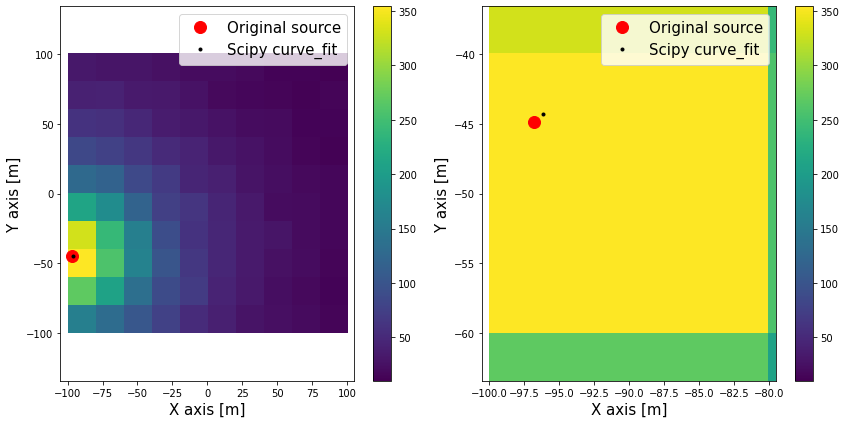

RANDOM
u = -96.46811292140158 ± 0.9895985701044081 m
v = -44.634181462164165 ± 0.6792769864448772 m
alpha = 602916.8436906288 ± 9199.815342033688 ?
A0 = 1345.7965260951537 ± 20.535302102753768 Bq


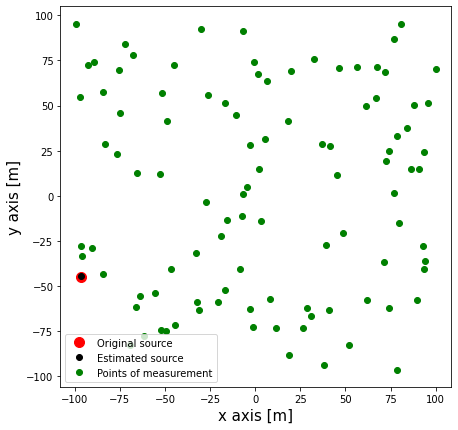

SPIRAL
u = -96.95244248166084 ± 0.21002179083657319 m
v = -45.125392935427094 ± 0.20793092010835487 m
alpha = 608470.5431677777 ± 1746.1634084753948 ?
A0 = 1358.1931767137896 ± 3.8976861796325784 Bq
search = 28


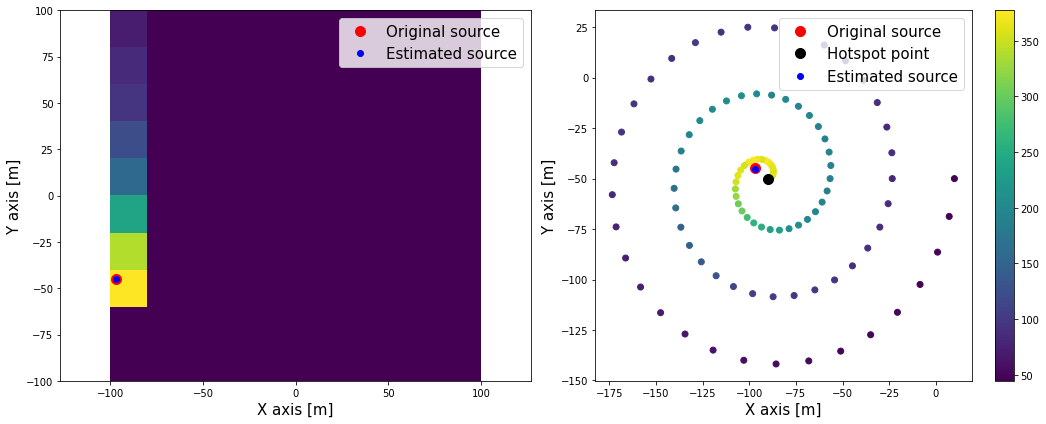

In [28]:

# SHARED PARAMETERS (USED IN BOTH ZIG-ZAG AND RANDOM FLYOVER)
A_min = 1e3; A_max = 1.5e3 # borders between which the activity of the source is randomly selected 
A_b = 5e-5 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 100 # Size of the area of flyover in positive x direction in m (the whole grid extends also in the negative direction the same amount)
y_max = 100 # Size of the area of flyover in positive y direction in m (the whole grid extends also in the negative direction the same amount)
dt = 10 # the pause on each point od the grid in s
noise = [5, 5] # list that contains the standard deviation of the x and y coordinates in in m
K = 0.8 # constant between 0 and 1 which contains the information on the quality of the detector, a better detector has a smaller constante 
        # then then an inferior detector
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq


# ZIG_ZAG PARAMETERS
grid = 10 # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the number of 
         # radioactive decays. Grid is the number of these areas in x direction and y direction. It must be an INTEGER!

# RANDOM AND IMPROVE PARAMETERS
n_points = 100 # fot the random_flyover() -> number of random points generated OR for improv_flyover() -> number of points in a spiral

# SPIRAL PARAMETERS
max_phi = 6*np.pi # rotation in radians that the detector will make will moving in a spiral trajectory
s_grid = 10


# Combinig the parameters into a list so that the data is more compacted
radiation = {'A_min': A_min, 'A_max': A_max, 'A_b': A_b, 'dose_factor': F}
detector = {"h": h, "dt": dt, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi, "spiral_grid": s_grid} # the detector constant tells us the quality of the detector

testSource = point_source(x_max, y_max, A_min, A_max)

print("ORIGINAL")
print("u =", testSource[0], "m")
print("v =", testSource[1], "m")
print("A0 =", testSource[2], "Bq", "\n")

# Flying over the surface
data = combination(radiation, detector, flyover, locationCF, testSource, [])
# print(data["sourceCF_stDev"])
# Print out the fitted parameters with their absolute errors (standard deviation)
print("ZIG-ZAG")
print("u =", data["sourceCF"][0], r'±', data["sourceCF_stDev"][0], "m")
print("v =", data["sourceCF"][1], r'±', data["sourceCF_stDev"][1], "m")
print("alpha =", data["sourceCF"][2], r'±', data["sourceCF_stDev"][2], "?")
print("A0 =", data['A0'][0], r'±', data['A0'][1], "Bq")

visualize(data)

# Random points over the surface
data_random = combination(radiation, detector, random_flyover, random_locationCF, testSource, [])
print("RANDOM")
print("u =", data_random["sourceCF"][0], r'±', data_random["sourceCF_stDev"][0], "m")
print("v =", data_random["sourceCF"][1], r'±', data_random["sourceCF_stDev"][1], "m")
print("alpha =", data_random["sourceCF"][2], r'±', data_random["sourceCF_stDev"][2], "?")
print("A0 =", data_random['A0'][0], r'±', data_random['A0'][1], "Bq")

random_visualize(data_random)

# testSource = [0, 0, 1500]

# Spiral points from the hotspot tile
data_spiral = combination(radiation, detector, spiral_flyover, spiral_locationCF, testSource)#source=problematic_source)
print("SPIRAL")
print("u =", data_spiral["sourceCF"][0], r'±', data_spiral["sourceCF_stDev"][0], "m")
print("v =", data_spiral["sourceCF"][1], r'±', data_spiral["sourceCF_stDev"][1], "m")
print("alpha =", data_spiral["sourceCF"][2], r'±', data_spiral["sourceCF_stDev"][2], "?")
print("A0 =", data_spiral['A0'][0], r'±', data_spiral['A0'][1], "Bq")
print("search =", data_spiral['search'])

spiral_visualize(data_spiral)



# Analysis

## Presenting some data

In [29]:
testSource = point_source(x_max, y_max, A_min, A_max)
testSource1 = point_source(x_max, y_max, A_min, A_max)
testSource2 = point_source(x_max, y_max, A_min, A_max)
source00 = [0, 0, testSource[2]]

print(testSource)
source00

[81.72719654955566, 94.47154426511094, 1384.0583666469236]


[0, 0, 1384.0583666469236]

In [30]:
# change the grid so that with a grid with more tiles the worse detector can get similar error to the first one
grid0 = 20
n_points0 = grid0**2
h0 = 40
noise = []
max_phi0 = 6*np.pi


# Analysis for detectors without noise, detector0 is an ideal detector and detector1 is a superior real detector to the real detector2
detector0 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid0, 'detector_constant': 0., "n_points": n_points0, "max_phi": max_phi0}
detector1 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid0, 'detector_constant': 0.1, "n_points": n_points0, "max_phi": max_phi0}
detector2 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid0, 'detector_constant': 0.8, "n_points": n_points0, "max_phi": max_phi0}

# We generate the data measurement and analysis for the same source, same grid and everything, the only difference between the detectors is K
data0 = combination(radiation, detector0, flyover, locationCF, testSource, noise)
data1 = combination(radiation, detector1, flyover, locationCF, source00, noise)
data2 = combination(radiation, detector1, flyover, locationCF, testSource, noise)

# Estimated source positions (with errors) 
u0, du0 = data0["sourceCF"][0], data0["sourceCF_stDev"][0]; v0, dv0 = data0["sourceCF"][1], data0["sourceCF_stDev"][1] 
u1, du1 = data1["sourceCF"][0], data1["sourceCF_stDev"][0]; v1, dv1 = data1["sourceCF"][1], data1["sourceCF_stDev"][1]
u2, du2 = data2["sourceCF"][0], data2["sourceCF_stDev"][0]; v2, dv2 = data2["sourceCF"][1], data2["sourceCF_stDev"][1]

# The (u, v) ± (du, dv)
# print("DETECTOR0:", "\n", (u0, v0), r'±', (du0, dv0), "m")
# print("DETECTOR1:", "\n", (u1, v1), r'±', (du1, dv1), "m")
# print("DETECTOR2:", "\n", (u2, v2), r'±', (du2, dv2), "m")

# Comparison between the error of the measurement for (0, 0) and (x, y) position of the source
print("Source in center:", "\n", (u1, v1), "+/-", (du1, dv1))
print("Source ourside:", "\n", (u2, v2), "+/-", (du2, dv2))




Source in center: 
 (0.014788214252399847, 0.04523403079208608) +/- (0.05710548892618262, 0.057110438456287334)
Source ourside: 
 (81.51235862016009, 94.54736491466008) +/- (0.13531377722937762, 0.17165673145391058)


## Error comparisson for different detector/measurement properties

### With errorbars

In [31]:
# errors compared to detectors with different grid, heights and qualities
testSource = point_source(x_max, y_max, A_min, A_max)

noise = []
grid0 = 20
n_points0 = grid0**2
max_phi0 = 6 * np.pi
s_grid = 5

detector1 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid0, 'detector_constant': 0.1, "n_points": n_points0, "max_phi": max_phi0, "spiral_grid": s_grid}


def compK_err(radiation, detector, N_grid, noise = []):
    Ks = np.linspace(0.3, 0.8, 20)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    U_yerr = []; rU_yerr = []; sU_yerr = []
    V_yerr = []; rV_yerr = []; sV_yerr = []
    for K in Ks:
        detector['detector_constant'] = K
        data = loopGRID(radiation, detector,  flyover, locationCF, N_grid, noise); random_data = loopGRID(radiation, detector, random_flyover, random_locationCF, N_grid, noise); spiral_data = loopGRID(radiation, detector, spiral_flyover, spiral_locationCF, N_grid, noise)
        dus.append(data['du']); r_dus.append(random_data['du']); s_dus.append(spiral_data['du'])
        dvs.append(data['dv']); r_dvs.append(random_data['dv']); s_dvs.append(spiral_data['dv'])
        U_yerr.append(data['d_du']); rU_yerr.append(random_data['d_du']); sU_yerr.append(spiral_data['d_du'])
        V_yerr.append(data['d_dv']); rV_yerr.append(random_data['d_dv']); sV_yerr.append(spiral_data['d_dv'])
    
    ZZ_u = erase_element(list(Ks), dus, U_yerr); ZZ_v = erase_element(list(Ks), dvs, V_yerr)
    draw([ZZ_u[0], ZZ_v[0]], [ZZ_u[1], ZZ_v[1]], {"u_yerr": ZZ_u[2], "v_yerr": ZZ_v[2]}, "Coefficient of the detector, K []", "Relative error []", "ZIG-ZAG")
    # draw(Ks, [r_dus, r_dvs], "Coefficient of the detector, K []", "Relative error []", "random")
    # draw(Ks, [s_dus, s_dvs], "Coefficient of the detectoe, K []", "Relative error []", "SPIRAL")

def compH_err(radiation, detector, N_grid, noise= []):
    hs = np.linspace(20, 100, 20)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    U_yerr = []; rU_yerr = []; sU_yerr = []
    V_yerr = []; rV_yerr = []; sV_yerr = []
    for h in hs:
        detector['h'] = h
        data = loopGRID(radiation, detector,  flyover, locationCF, N_grid, noise); random_data = loopGRID(radiation, detector, random_flyover, random_locationCF, N_grid, noise); spiral_data = loopGRID(radiation, detector, spiral_flyover, spiral_locationCF, N_grid, noise)
        dus.append(data['du']); r_dus.append(random_data['du']); s_dus.append(spiral_data['du'])
        dvs.append(data['dv']); r_dvs.append(random_data['dv']); s_dvs.append(spiral_data['dv'])
        U_yerr.append(data['d_du']); rU_yerr.append(random_data['d_du']); sU_yerr.append(spiral_data['d_du'])
        V_yerr.append(data['d_dv']); rV_yerr.append(random_data['d_dv']); sV_yerr.append(spiral_data['d_dv'])  
    
    ZZ_u = erase_element(list(hs), dus, U_yerr); ZZ_v = erase_element(list(hs), dvs, V_yerr)
    draw([ZZ_u[0], ZZ_v[0]], [ZZ_u[1], ZZ_v[1]], {"u_yerr": ZZ_u[2], "v_yerr": ZZ_v[2]}, "Height of flyover [m]", "Relative error []", "ZIG-ZAG")
    # draw(hs, [r_dus, r_dvs], "Height of flyover [m]", "Relative error []", "random")
    # draw(hs, [s_dus, s_dvs], "Height of flyover [m]", "Relative error []", "SPIRAL")

def compG_err(radiation, detector, N_grid, noise = []):
    grids = np.linspace(3, 42, 10)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    U_yerr = []; rU_yerr = []; sU_yerr = []
    V_yerr = []; rV_yerr = []; sV_yerr = []
    for grid in grids:
        detector['grid'] = int(grid)
        data = loopGRID(radiation, detector,  flyover, locationCF, N_grid, noise); random_data = loopGRID(radiation, detector, random_flyover, random_locationCF, N_grid, noise); spiral_data = loopGRID(radiation, detector, spiral_flyover, spiral_locationCF, N_grid, noise)
        dus.append(data['du']); r_dus.append(random_data['du']); s_dus.append(spiral_data['du'])
        dvs.append(data['dv']); r_dvs.append(random_data['dv']); s_dvs.append(spiral_data['dv'])
        U_yerr.append(data['d_du']); rU_yerr.append(random_data['d_du']); sU_yerr.append(spiral_data['d_du'])
        V_yerr.append(data['d_dv']); rV_yerr.append(random_data['d_dv']); sV_yerr.append(spiral_data['d_dv'])
    
    # draw([grids, grids], [dus, dvs], {"u_yerr": U_yerr, "v_yerr": V_yerr}, "Coefficient of the detector, K []", "Relative error []", "ZIG-ZAG")
    ZZ_u = erase_element(list(grids), dus, U_yerr); ZZ_v = erase_element(list(grids), dvs, V_yerr)
    draw([ZZ_u[0], ZZ_v[0]], [ZZ_u[1], ZZ_v[1]], {"u_yerr": ZZ_u[2], "v_yerr": ZZ_v[2]}, "Number of grid points []", "Relative error []", "ZIG-ZAG")
    # draw(grids, [r_dus, r_dvs], "Number of grid points []", "Relative error []", "random")
    # draw(grids, [s_dus, s_dvs], "Number of grid points []", "Relative error []", "SPIRAL")

def compT_err(radiation, detector, N_grid, noise = []):
    dts = np. linspace(100, 1000, 20)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    U_yerr = []; rU_yerr = []; sU_yerr = []
    V_yerr = []; rV_yerr = []; sV_yerr = []
    for dt in dts:
        detector['dt'] = dt
        data = loopGRID(radiation, detector,  flyover, locationCF, N_grid, noise); random_data = loopGRID(radiation, detector, random_flyover, random_locationCF, N_grid, noise); spiral_data = loopGRID(radiation, detector, spiral_flyover, spiral_locationCF, N_grid, noise)
        dus.append(data['du']); r_dus.append(random_data['du']); s_dus.append(spiral_data['du'])
        dvs.append(data['dv']); r_dvs.append(random_data['dv']); s_dvs.append(spiral_data['dv'])
        U_yerr.append(data['d_du']); rU_yerr.append(random_data['d_du']); sU_yerr.append(spiral_data['d_du'])
        V_yerr.append(data['d_dv']); rV_yerr.append(random_data['d_dv']); sV_yerr.append(spiral_data['d_dv'])
    
    # draw([grids, grids], [dus, dvs], {"u_yerr": U_yerr, "v_yerr": V_yerr}, "Coefficient of the detector, K []", "Relative error []", "ZIG-ZAG")
    ZZ_u = erase_element(list(dts), dus, U_yerr); ZZ_v = erase_element(list(dts), dvs, V_yerr)
    draw([ZZ_u[0], ZZ_v[0]], [ZZ_u[1], ZZ_v[1]], {"u_yerr": ZZ_u[2], "v_yerr": ZZ_v[2]}, "Time of measurement at each grid point [s]", "Relative error []", "ZIG-ZAG")
    # draw(dts, [r_dus, r_dvs], "Time of measurement at each grid point [s]", "Relative error []", "random")
    # draw(dts, [s_dus, s_dvs], "Time of measurement ar each grid point [s]", "Relative error []", "SPIRAL")


def loopGRID(radiation, detector, func_fo, func_CF, N_grid, noise = []):
    
    A_min = radiation['A_min']; A_max = radiation['A_max']
    x_max = detector['x_max']; y_max = detector['y_max']

    D_x = 2*x_max/N_grid
    D_y = 2*y_max/N_grid

    xs = np.linspace(-x_max + D_x/2, x_max - D_x/2, int(N_grid))
    ys = np.linspace(-y_max + D_y/2, y_max - D_y/2, int(N_grid))
    dus = []; dvs = []
    for x in xs:
        for y in ys:
            #FIXED if (x < (x_max - D_x)) and (y < (y_max - D_y)): # For the bottom left tile the spiral code has some error of unkonown origin
            Source = [random.uniform(x - D_x/2, x + D_x/2), random.uniform(y - D_y/2, y + D_y/2), (A_max + A_min)/2]
            data = combination(radiation, detector, func_fo, func_CF, Source, noise)
            dus.append(data['sourceCF_stDev'][0]/abs(data['sourceCF'][0])); dvs.append(data['sourceCF_stDev'][1]/abs(data['sourceCF'][1]))

    return {"du": np.mean(np.array(dus)), "d_du": np.std(np.array(dus)), "dv": np.mean(np.array(dvs)), "d_dv": np.std(np.array(dvs))}

def erase_element(x_data, y_data, yerr):
    MyMedian = statistics.median(yerr)
    elements1 = []; elements2 = []; elements3 = []
    for i in range(len(yerr)):
        if 1.5*MyMedian < yerr[i]:
            elements1.append(yerr[i])
            elements2.append(x_data[i])
            elements3.append(y_data[i])
    for i in range(len(elements1)):
        yerr.remove(elements1[i])
        x_data.remove(elements2[i])
        y_data.remove(elements3[i])
    return [x_data, y_data, yerr]

def draw(xs, ys, yerr, name_x = "", name_y = "", tit = ""):

    u_yerr = yerr['u_yerr']
    plt.errorbar(xs[0], ys[0], yerr = u_yerr, fmt = ".", label = "u-error")

    if len(ys) == 2:
        v_yerr = yerr['v_yerr']
        plt.errorbar(xs[1], ys[1], yerr = v_yerr, fmt = ".", label = "v-error")

    plt.xlabel(name_x, fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel(name_y, fontsize = 15)
    plt.yticks(fontsize = 14)

    plt.title(tit)

    # plt.savefig("graphics/err_to_K.png")
    plt.legend()
    plt.show()


# compK_err(radiation, detector1, 5)
# compH_err(radiation, detector1, 5)
# compG_err(radiation, detector1, 5)
# compT_err(radiation, detector1, 5)

# Comment: the uncertianty increasies with the detector coefficient.


### Without errorbars

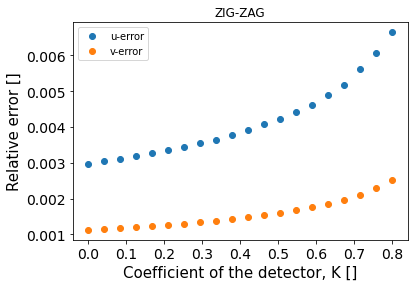

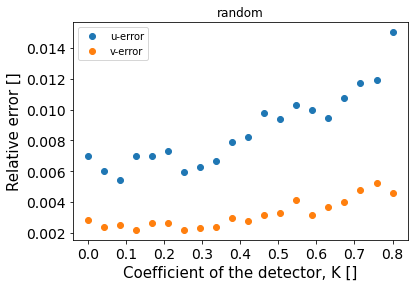

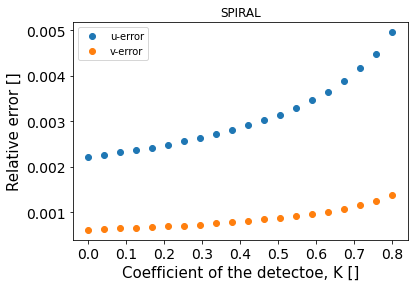

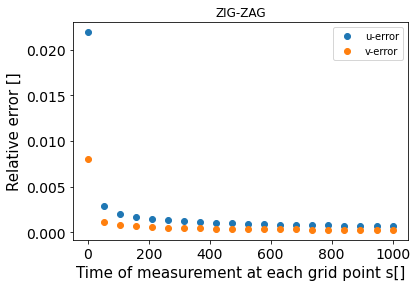

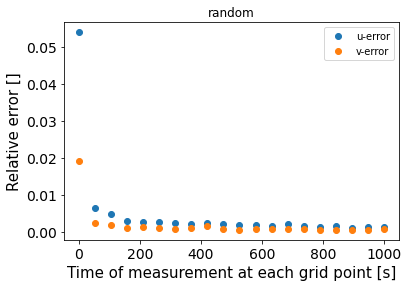

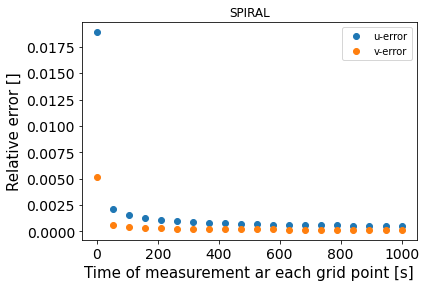

In [32]:

# errors compared to detectors with different grid, heights and qualities
testSource = point_source(x_max, y_max, A_min, A_max)

noise = []
grid0 = 20
n_points0 = grid0**2
max_phi0 = 6 * np.pi
s_grid = 5

detector1 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid0, 'detector_constant': 0.1, "n_points": n_points0, "max_phi": max_phi0, "spiral_grid": s_grid}

def lin(x, k, n):
    return k*x + n

def compK(radiation, detector, source, noise = []):
    Ks = np.linspace(0, 0.8, 20)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    for K in Ks:
        detector['detector_constant'] = K
        data = combination(radiation, detector, flyover, locationCF, source, noise); random_data = combination(radiation, detector, random_flyover, random_locationCF, source, noise); spiral_data = combination(radiation, detector, spiral_flyover, spiral_locationCF, source)
        dus.append(data['sourceCF_stDev'][0]/abs(data['sourceCF'][0])); r_dus.append(random_data['sourceCF_stDev'][0]/abs(random_data['sourceCF'][0])); s_dus.append(spiral_data['sourceCF_stDev'][0]/abs(spiral_data['sourceCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['sourceCF'][1])); r_dvs.append(random_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1])); s_dvs.append(spiral_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1]))

    draw(Ks, [dus, dvs], "Coefficient of the detector, K []", "Relative error []", "ZIG-ZAG")
    draw(Ks, [r_dus, r_dvs], "Coefficient of the detector, K []", "Relative error []", "random")
    draw(Ks, [s_dus, s_dvs], "Coefficient of the detectoe, K []", "Relative error []", "SPIRAL")

def compH(radiation, detector, source, noise= []):
    hs = np.linspace(20, 100, 20)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    for h in hs:
        detector['h'] = h
        data = combination(radiation, detector, flyover, locationCF, source, noise); random_data = combination(radiation, detector, random_flyover, random_locationCF, source, noise); spiral_data = combination(radiation, detector, spiral_flyover, spiral_locationCF, source)
        dus.append(data['sourceCF_stDev'][0]/abs(data['sourceCF'][0])); r_dus.append(random_data['sourceCF_stDev'][0]/abs(random_data['sourceCF'][0])); s_dus.append(spiral_data['sourceCF_stDev'][0]/abs(spiral_data['sourceCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['sourceCF'][1])); r_dvs.append(random_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1])); s_dvs.append(spiral_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1]))
    draw(hs, [dus, dvs], "Height of flyover [m]", "Relative error []", "ZIG-ZAG")
    draw(hs, [r_dus, r_dvs], "Height of flyover [m]", "Relative error []", "random")
    draw(hs, [s_dus, s_dvs], "Height of flyover [m]", "Relative error []", "SPIRAL")

def compG(radiation, detector, source, noise = []):
    grids = np.linspace(2, 42, 10)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    for grid in grids:
        detector['grid'] = int(grid)
        detector['n_points'] = int(grid)**2
        data = combination(radiation, detector, flyover, locationCF, source, noise); random_data = combination(radiation, detector, random_flyover, random_locationCF, source, noise); spiral_data = combination(radiation, detector, spiral_flyover, spiral_locationCF, source)
        dus.append(data['sourceCF_stDev'][0]/abs(data['sourceCF'][0])); r_dus.append(random_data['sourceCF_stDev'][0]/abs(random_data['sourceCF'][0])); s_dus.append(spiral_data['sourceCF_stDev'][0]/abs(spiral_data['sourceCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['sourceCF'][1])); r_dvs.append(random_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1])); s_dvs.append(spiral_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1]))
    draw(grids, [dus, dvs], "Number of grid points []", "Relative error []", "ZIG-ZAG")
    draw(grids, [r_dus, r_dvs], "Number of grid points []", "Relative error []", "random")
    draw(grids, [s_dus, s_dvs], "Number of grid points []", "Relative error []", "SPIRAL")

def compT(radiation, detector, source, noise = []):
    dts = np. linspace(1, 1000, 20)
    dus = []; r_dus = []; s_dus = []
    dvs = []; r_dvs = []; s_dvs = []
    for dt in dts:
        detector['dt'] = dt
        data = combination(radiation, detector, flyover, locationCF, source, noise); random_data = combination(radiation, detector, random_flyover, random_locationCF, source, noise); spiral_data = combination(radiation, detector, spiral_flyover, spiral_locationCF, source)
        dus.append(data['sourceCF_stDev'][0]/abs(data['sourceCF'][0])); r_dus.append(random_data['sourceCF_stDev'][0]/abs(random_data['sourceCF'][0])); s_dus.append(spiral_data['sourceCF_stDev'][0]/abs(spiral_data['sourceCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['sourceCF'][1])); r_dvs.append(random_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1])); s_dvs.append(spiral_data['sourceCF_stDev'][1]/abs(random_data['sourceCF'][1]))
    draw(dts, [dus, dvs], "Time of measurement at each grid point s[]", "Relative error []", "ZIG-ZAG")
    draw(dts, [r_dus, r_dvs], "Time of measurement at each grid point [s]", "Relative error []", "random")
    draw(dts, [s_dus, s_dvs], "Time of measurement ar each grid point [s]", "Relative error []", "SPIRAL")

def comp_randToG(radiation, detetctor, source, noise = []):
    grids = np.linspace(4, 42, 20)
    dus = []
    dvs = []
    measured_points = []
    for grid in grids:
        detector['grid'] = int(grid); n_points = int(grid)**2
        measured_points.append(n_points)
        data_G = combination(radiation, detector, flyover, locationCF, source, noise)
        data_R = combination(radiation, detector, random_flyover, random_locationCF, source, noise)
        d_UR = data_R['sourceCF_stDev'][0]; d_UG = data_G['sourceCF_stDev'][0]
        d_VR = data_R['sourceCF_stDev'][1]; d_VG = data_G['sourceCF_stDev'][1]

        dus.append(d_UR - d_VR)

    draw(measured_points, [dus], "Number of measurement points []", "Differenc between relative errors")

def draw(xs, ys, name_x = "", name_y = "", tit = ""):
    plt.plot(list(xs), ys[0], "o", label = "u-error")
    if len(ys) == 2:
        plt.plot(list(xs), ys[1], "o", label = "v-error")

    plt.xlabel(name_x, fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel(name_y, fontsize = 15)
    plt.yticks(fontsize = 14)

    plt.title(tit)

    # plt.savefig("graphics/err_to_K.png")
    plt.legend()
    plt.show()

def fit_func(func, xdata, ydata, xlabel, ylabel):

    popt, pcov = curve_fit(func, xdata, ydata)

    print(popt)

    plt.plot(xdata, ydata, "o", label = "Data")
    plt.plot(xdata, [func(x, *popt) for x in xdata], "-", label = "Fit")

    plt.xlabel(xlabel, fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel(ylabel, fontsize = 15)
    plt.yticks(fontsize = 14)

    plt.show()

compK(radiation, detector1, testSource)
# compH(radiation, detector, testSource)
# compG(radiation, detector0, testSource)
compT(radiation, detector1, testSource)
# comp_randToG(radiation, detector0, testSource)

## Standar deviation for source in (0,0)

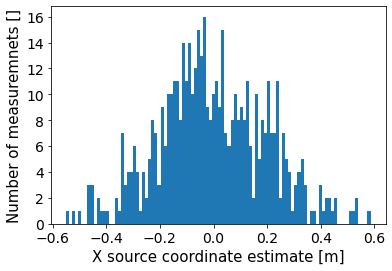

FROM SIMULATION: 
 0.2002168140281277
 
DETECTOR1: 
 0.20140405157028923


In [33]:
detector1 = {'h': 40, 'dt': 10, 'x_max': 100, 'y_max': 100, 'grid': 10, 'detector_constant': 0.6, "n_points": 100, "max_phi": 6*np.pi, 'spiral_grid': 10}

def loopstDev(radiation, detector, n_sims, noise=[], A0 = 1000):
    us = []; dus = []
    source00 = [0, 0, A0]
    for n in range(n_sims):
        data = combination(radiation, detector, flyover, locationCF, source00, noise)
        u = data['sourceCF'][0]#; v = data['source_locationCF'][1]
        du = data['sourceCF_stDev'][0]
        us.append(u); dus.append(du)

    plt.hist(us, bins=100)
    plt.xlabel("X source coordinate estimate [m]", fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel("Number of measuremnets []", fontsize = 15)
    plt.yticks(fontsize = 14)

    plt.show()
    print("FROM SIMULATION:", "\n", np.std(us))
    return " "


print(loopstDev(radiation, detector1, 500))

A0 = 1000; source00 = [0, 0, A0]
data = combination(radiation, detector1, flyover, locationCF, source00)
print('DETECTOR1:', "\n", data['sourceCF_stDev'][0])


## Comparison at each grid tile 

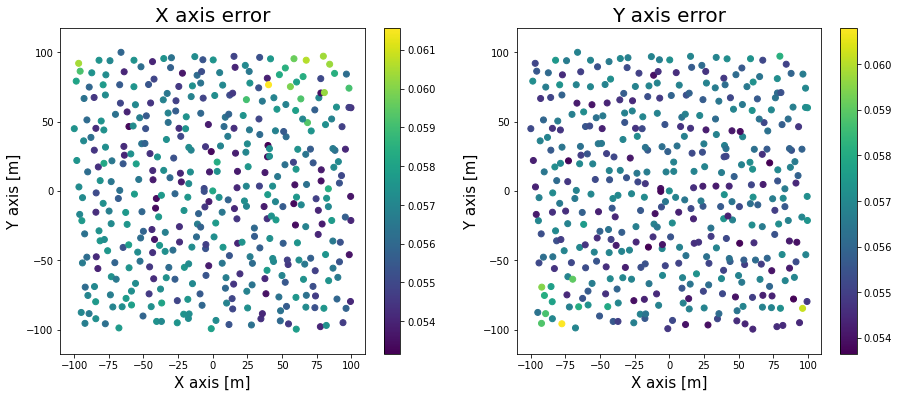

In [34]:
noise = []
grid0 = 20
n_points0 = grid0**2
max_phi0 = 6 * np.pi
s_grid = 10

detector1 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid0, 'detector_constant': 0.1, "n_points": n_points0, "max_phi": max_phi0, "spiral_grid": s_grid}
# detector1 = {"h": h, "dt": dt, "x_max": 100, "y_max": 100, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi, "spiral_grid": 10}

# check if the error is noticably larger for points outside of the center source (0, 0)
def loopOverGrid00(radiation, detector, func_combination, func_fo, func_CF,  A0 = 1000):

    A_min = radiation['A_min']; A_max = radiation['A_max']
    N_grid = detector['grid']; x_max = detector['x_max']; y_max = detector['y_max']

    source00 = [0, 0, A0]
    data0 = func_combination(radiation, detector, func_fo, func_CF, source00)
    du0 = data0['sourceCF_stDev'][0]; dv0 = data0['sourceCF_stDev'][1]

    D_x = 2*x_max/N_grid
    D_y = 2*y_max/N_grid

    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    X = np.zeros((N_grid, N_grid)); Y = np.zeros((N_grid, N_grid))
    Zus = np.zeros((N_grid, N_grid)); Zvs = np.zeros((N_grid, N_grid))
    i, j = 0, 0
    problems = []
    for x in xs:
        for y in ys:
            #FIXED if (x < (x_max - D_x)) and (y < (y_max - D_y)): # For the bottom left tile the spiral code has some error of unkonown origin
            Source = point_source(x + square_x/2, y + square_y/2, A_min, A_max, x - square_x/2, y - square_y/2)
            Source[-1] = A0
            data = func_combination(radiation, detector, func_fo, func_CF, Source)
            du = data['sourceCF_stDev'][0]; dv = data['sourceCF_stDev'][1]

            X[i, j] = Source[0]; Y[i, j] = Source[1]
            Zus[i, j] = du; Zvs[i, j] = dv
            j += 1
        j = 0
        i += 1

    X[N_grid - 1, N_grid - 1], Y[N_grid - 1, N_grid - 1] = 0, 0
    Zus[N_grid - 1, N_grid - 1] = du0; Zvs[N_grid - 1, N_grid - 1] = dv0

    fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(15, 6))

    test1 = ax1.scatter(X, Y, c=Zus)
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
    ax1.set_title('X axis error', fontsize = 20)
    ax1.axis("equal")

    test2 = ax2.scatter(X, Y, c=Zvs)
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)
    ax2.set_title('Y axis error', fontsize = 20)
    ax2.axis("equal")

    fig.colorbar(test1, ax=ax1)
    fig.colorbar(test2, ax=ax2)
    plt.show()

loopOverGrid00(radiation, detector1, combination, spiral_flyover, spiral_locationCF)



## Method comparisson

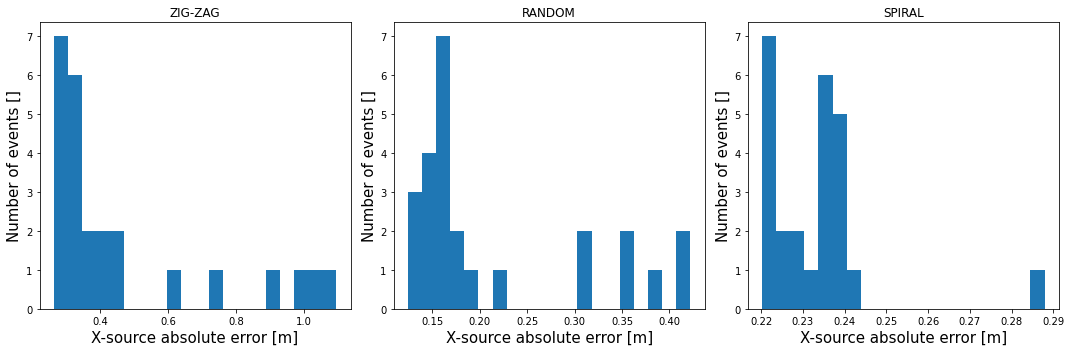

None


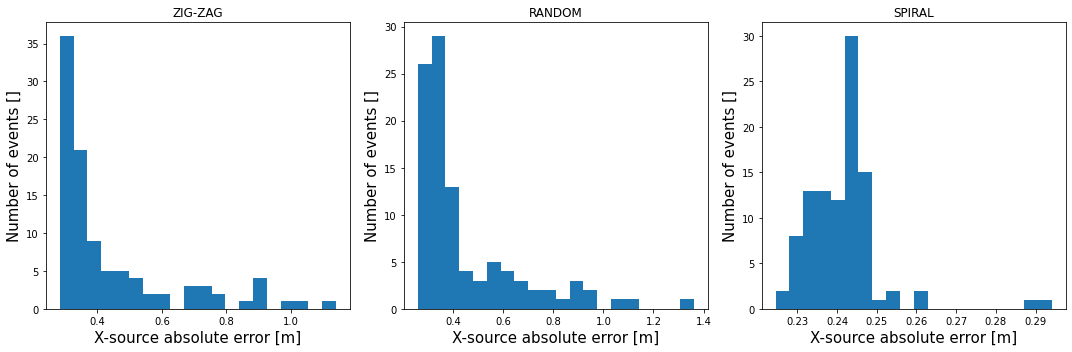

None


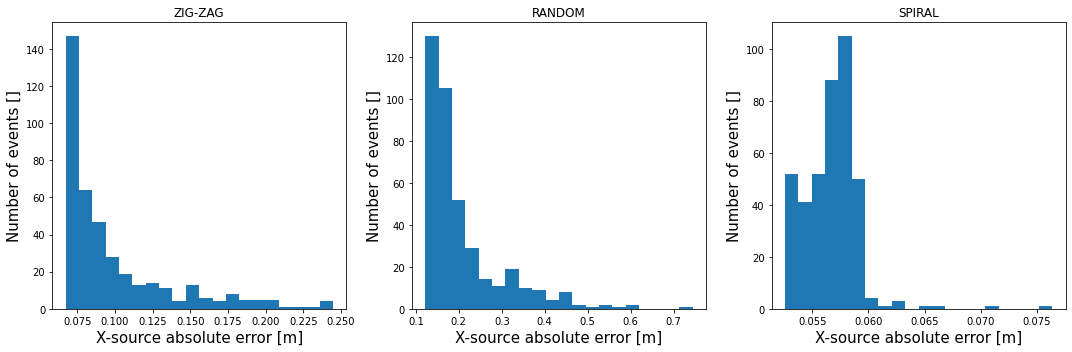

None


In [35]:
noise = []
grid0 = 20; grid1 = 5
n_points0 = grid0**2; n_points1 = grid1**2
max_phi = 6*np.pi
s_grid = 5

detector0 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid0, 'detector_constant': 0.1, "n_points": n_points0, "max_phi": max_phi0, "spiral_grid": s_grid}
detector1 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid1, 'detector_constant': 0.1, "n_points": n_points1, "max_phi": max_phi0, "spiral_grid": s_grid}

# for each grid tile generate a random point and find the error for source estimate with each method. Present the result as histogram
def method_comp(radiation, detector, noise = [], A0 = 1000):
    A_min = radiation['A_min']; A_max = radiation['A_max']
    x_max = detector['x_max']; y_max = detector['y_max']; N_grid = detector['grid']

    D_x = 2*x_max/N_grid
    D_y = 2*y_max/N_grid 

    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))

    zigZag = []; random = []; spiral = []
    i, j = 0, 0
    for x in xs:
        for y in ys:
            Source = point_source(x + square_x/2, y + square_y/2, A_min, A_max, x - square_x/2, y - square_y/2)
            Source[-1] = A0
            # if (x < (x_max - D_x)) and (y < (y_max - D_y)): # For the bottom left tile the spiral code has some error of unkonown origin
            data_spi = combination(radiation, detector, spiral_flyover, spiral_locationCF, Source)
            du_spi = data_spi['sourceCF_stDev'][0]
            spiral.append(du_spi)
            
            data_zig = combination(radiation, detector, flyover, locationCF, Source)
            data_ran = combination(radiation, detector, random_flyover, random_locationCF, Source)
            du_zig = data_zig['sourceCF_stDev'][0]; du_ran = data_ran['sourceCF_stDev'][0]
            zigZag.append(du_zig); random.append(du_ran)
            
            j += 1
        j = 0
        i += 1

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

    ax1.hist(np.array(zigZag), bins = 20)
    ax1.set_xlabel("X-source absolute error [m]", fontsize=15)
    ax1.set_ylabel("Number of events []", fontsize=15)
    ax1.set_title("ZIG-ZAG")

    ax2.hist(np.array(random), bins = 20)
    ax2.set_xlabel("X-source absolute error [m]", fontsize=15)
    ax2.set_ylabel("Number of events []", fontsize=15)
    ax2.set_title("RANDOM")

    ax3.hist(np.array(spiral), bins = 20)
    ax3.set_xlabel("X-source absolute error [m]", fontsize=15)
    ax3.set_ylabel("Number of events []", fontsize=15)
    ax3.set_title("SPIRAL")

    plt.tight_layout()
    plt.show()

    # return

print(method_comp(radiation, detector1)) # 25 measurements made
print(method_comp(radiation, detector)) # 100 measurements made
print(method_comp(radiation, detector0)) # 400 measurements made


## Further spiral analysis

### Dependancy to size of s_grid

In [36]:
# place source at centre and increse the number of s-grid that you use to locate the "hotspot" tile. In spiral make the same number of 
# measurements for every iteration. Observe the change in location uncertianty

detector1 = {'h': 40, 'dt': 10, 'x_max': 100, 'y_max': 100, 'grid': 10, 'detector_constant': 0.8, "n_points": 100, "max_phi": 6*np.pi, 'spiral_grid': 10}
detector2 = {'h': 40, 'dt': 10, 'x_max': 100, 'y_max': 100, 'grid': 10, 'detector_constant': 0.1, "n_points": 100, "max_phi": 6*np.pi, 'spiral_grid': 10}
s_range = np.linspace(2, 100, 49)
source00 = [0, 0, 1000]

def s_gridLOOP(radiation, detector, s_gridRange, source00):
    dus = []; dvs = []; s_grids = []
    i = 0
    for s_grid in s_gridRange:
        detector['spiral_grid'] = int(s_grid)
        data = combination(radiation, detector, spiral_flyover, spiral_locationCF, source00)
        du = data['sourceCF_stDev'][0]; dv = data['sourceCF_stDev'][1]; s_grids.append(s_grid)
        # print out the s_grid where the first bigg error jump occurs
        if len(dus) != 0 and dus[-1]*2 < du and i == 0:
            first = int(s_grid)
            i = 1
        dus.append(du); dvs.append(dv)
    # draw(s_grids, [dus, dvs], "Number of spiral grids []", "Source estimate absolute error [m]", None)
    return first

s_gridLOOP(radiation, detector1, s_range, source00)

list1 = []
for i in range(10):
    list1.append(s_gridLOOP(radiation, detector1, s_range, source00))
print("Za K = 0.8 povprečen začetek višanja napake:", "\n", sum(list1)/len(list1))

list2 = []
for i in range(10):
    list2.append(s_gridLOOP(radiation, detector2, s_range, source00))
print("Za K = 0.1 povprečen začetek višanja napake:", "\n", sum(list2)/len(list2))



Za K = 0.8 povprečen začetek višanja napake: 
 30.6
Za K = 0.1 povprečen začetek višanja napake: 
 44.3


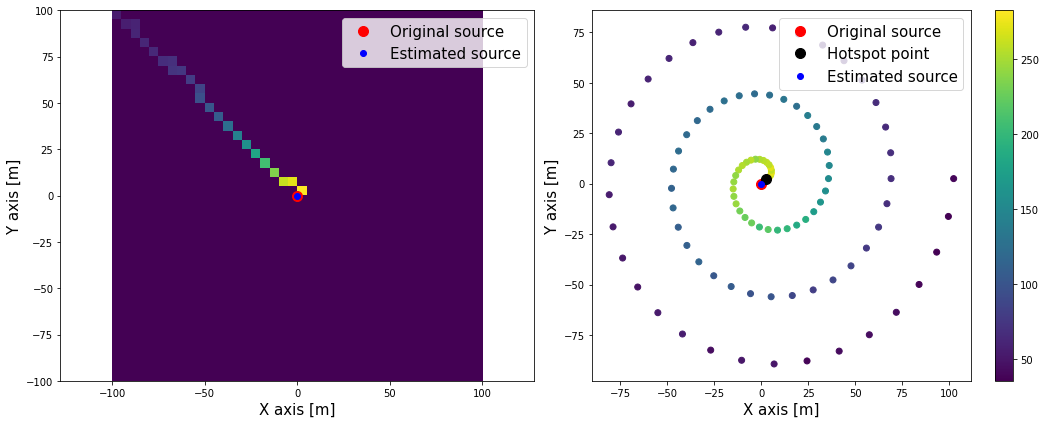

In [37]:

detector1 = {'h': 40, 'dt': 10, 'x_max': 100, 'y_max': 100, 'grid': 10, 'detector_constant': 0.8, "n_points": 100, "max_phi": 6*np.pi, 'spiral_grid': 40}
detector2 = {'h': 40, 'dt': 10, 'x_max': 100, 'y_max': 100, 'grid': 10, 'detector_constant': 0.1, "n_points": 100, "max_phi": 6*np.pi, 'spiral_grid': 10}

data = combination(radiation, detector1, spiral_flyover, spiral_locationCF, source00)
spiral_visualize(data)

### Size of grid compared to s_grid

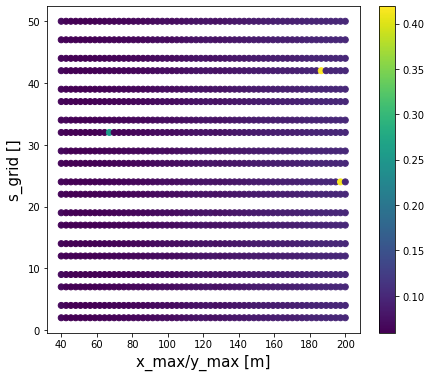

array([[0.06658151, 0.06819897, 0.06658792, ..., 0.06472657, 0.06470387,
        0.06812667],
       [0.06166158, 0.06390042, 0.06165576, ..., 0.06385446, 0.06168119,
        0.06304314],
       [0.06003074, 0.06007142, 0.06009654, ..., 0.06005229, 0.0609496 ,
        0.061431  ],
       ...,
       [0.09849335, 0.09843399, 0.09859556, ..., 0.09872668, 0.09850499,
        0.09854358],
       [0.09908944, 0.09893559, 0.09893871, ..., 0.09914348, 0.09899845,
        0.09891833],
       [0.09923585, 0.09926828, 0.09928128, ..., 0.09922686, 0.09948103,
        0.09928003]])

In [38]:
# Trying to find the optimal number s_grid for a certian size of grid. The criteria is that the error will remain the same - so the question 
# basically is how much do we have to increase the s_grid when the whole grid area is larger so that we keep the error constant. The test wil 
# be made for the poinst source at position (0, 0)

# parameters that shouldn't be changed for both detectors
h = 40; dt = 20; grid = 8; K = 0.1; n_points = 100; max_phi = 6*np.pi
# + radiation from Man code component
source00A = [0, 0, (A_min + A_max)/2]

# First compare errors for two drastically different grids (by x_max and y_max) and the same number s_grid.
detector1 = {"h": h, "dt": dt, "x_max": 50, "y_max": 50, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi, "spiral_grid": 20}
detector2 = {"h": h, "dt": dt, "x_max": 50, "y_max": 50, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi, "spiral_grid": 5}

sourceFAR = [detector1['x_max'], -detector1['y_max'], (A_min + A_max)/2]

data1 = combination(radiation, detector1, spiral_flyover, spiral_locationCF, source=source00A)
data2 = combination(radiation, detector2, spiral_flyover, spiral_locationCF, source=source00A)

# print("Detector1:", "\n", data1["sourceCF_stDev"][0])
# print("Detector2:", "\n", data2["sourceCF_stDev"][0])
# ("Dosen't seem to be as expected")

# make a graph to see whats up

def grid_to_S00A(radiation, detector, source):
    XY_maxs = np.linspace(40, 200, 60)
    s_grids = np.linspace(2, 50, 20)
    n_XY = len(list(XY_maxs)); n_g = len(list(s_grids))

    i, j = 0, 0
    array_XY = np.ones((n_XY, n_g)); array_S = np.ones((n_XY, n_g)); array_du = np.ones((n_XY, n_g))
    for XY_max in XY_maxs:
        for s_grid in s_grids:
            detector['x_max'] = XY_max; detector['y_max'] = XY_max
            detector['s_grid'] = int(s_grid)
            data = combination(radiation, detector, spiral_flyover, spiral_locationCF, source)
            du = data['sourceCF_stDev'][0]
            array_XY[i, j] = XY_max; array_S[i, j] = int(s_grid)
            array_du[i, j] = du
            j += 1
        j = 0
        i += 1

    fig, ax = plt.subplots(figsize = (7, 6))

    im1 = ax.scatter(array_XY, array_S, c = array_du)

    ax.set_xlabel("x_max/y_max [m]", fontsize = 15)
    ax.set_ylabel("s_grid []", fontsize = 15)

    fig.colorbar(im1, ax=ax)

    plt.show()

    return array_du

grid_to_S00A(radiation, detector1, sourceFAR)


## Other things

40.0
[-74.34377273360741, -78.72235170312696, 1388.6424116487153]


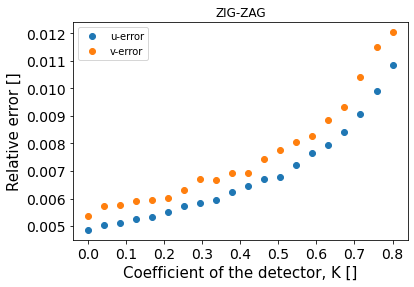

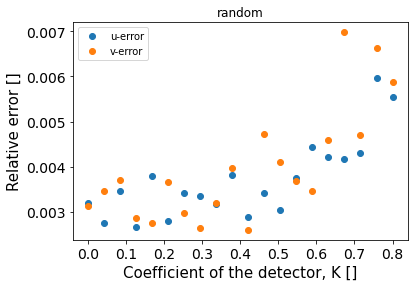

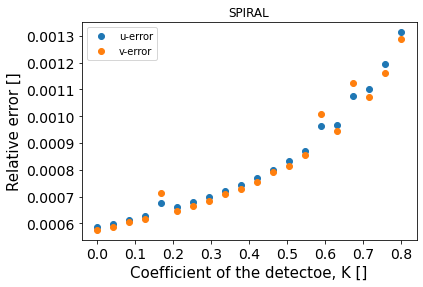

[-82.40038305563682, -41.17751979522224, 1161.1833318305494]


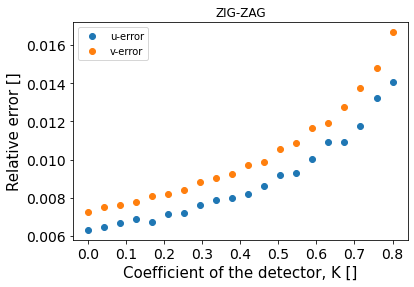

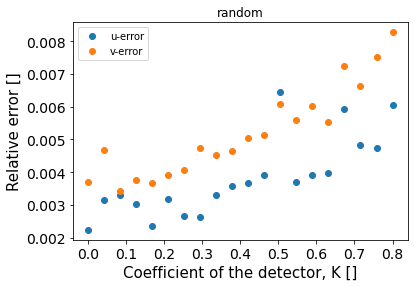

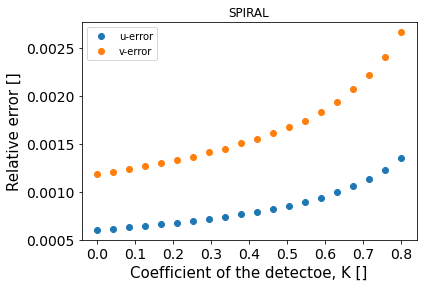

[-90.56333027490366, -18.912485969821383, 1273.2485261891147]


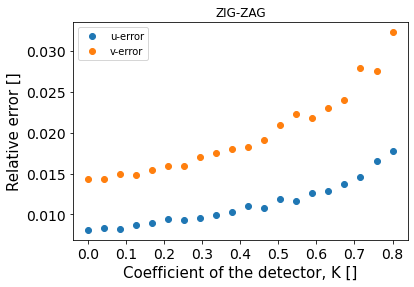

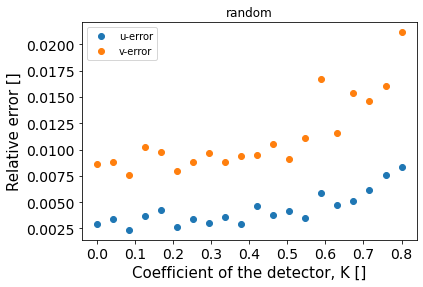

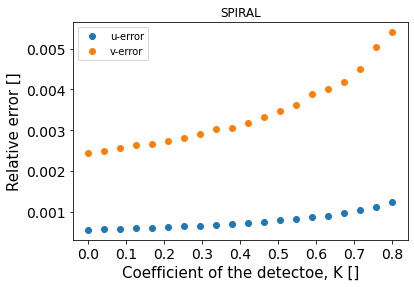

[-96.23189813730437, 46.61525186396074, 1449.430959205209]


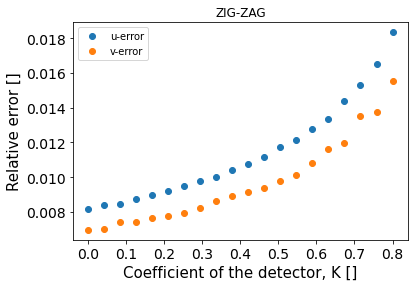

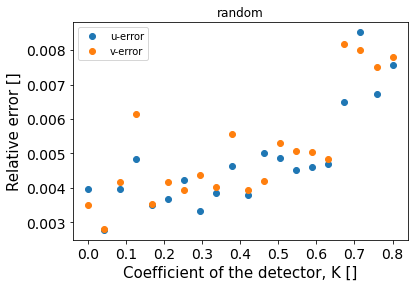

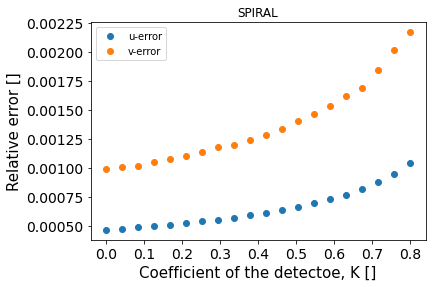

[-87.7362425970337, 78.4620429433388, 1486.5855717589336]


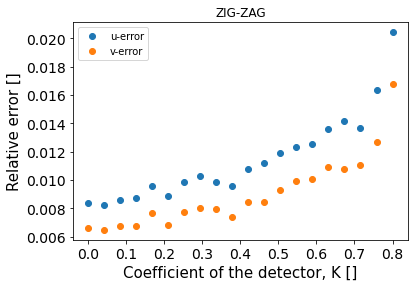

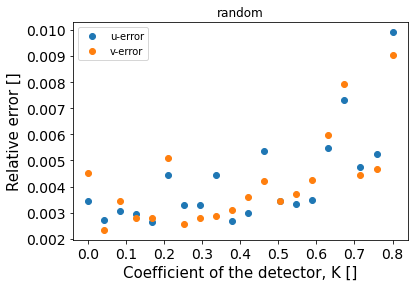

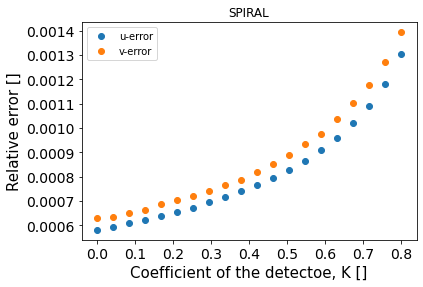

[-28.66090805714294, -90.85184931068495, 1116.595585908841]


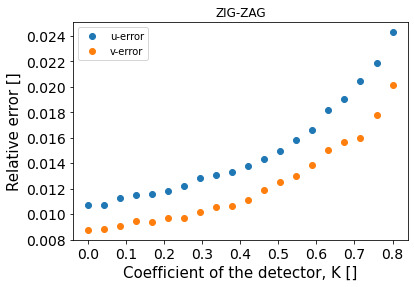

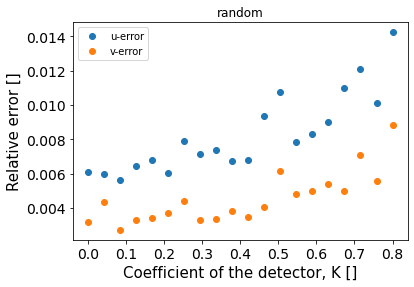

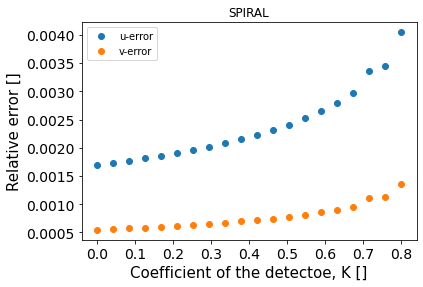

[-35.22243116716375, -46.205455863698276, 1079.1916422901418]


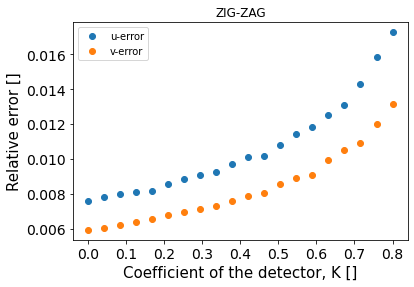

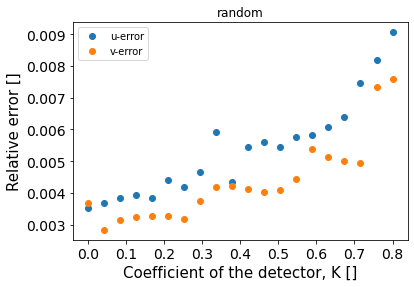

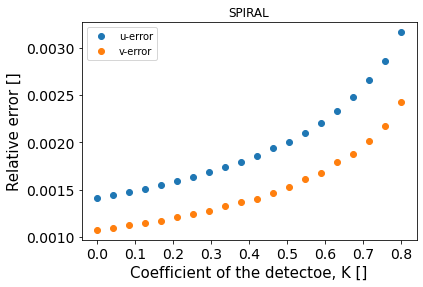

[-20.87353894448163, -8.46236093311941, 1412.6473188109449]


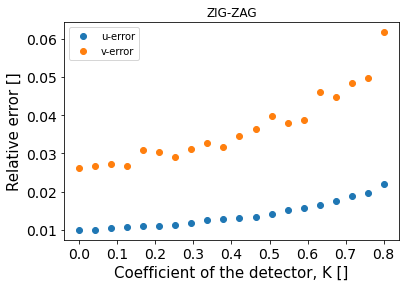

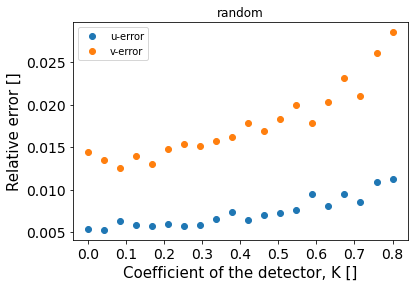

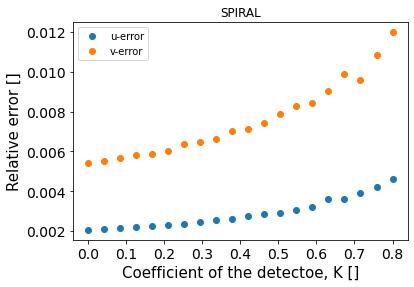

[-43.45335358734023, 39.32244429872589, 1400.931468655213]


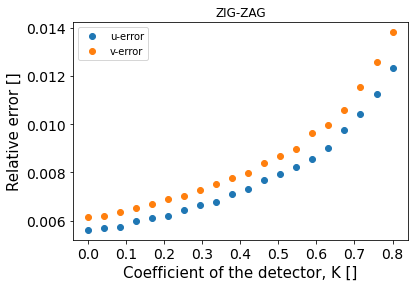

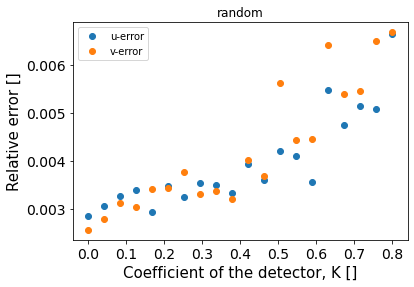

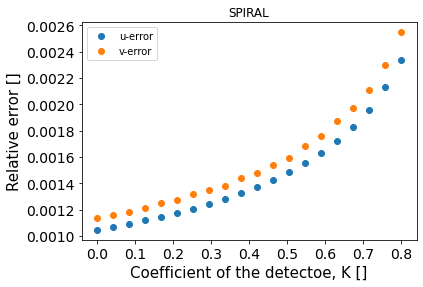

[-55.930687241163405, 92.26714280329112, 1319.917060229482]


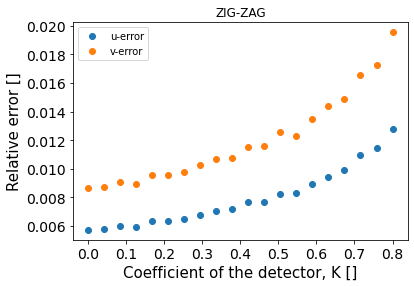

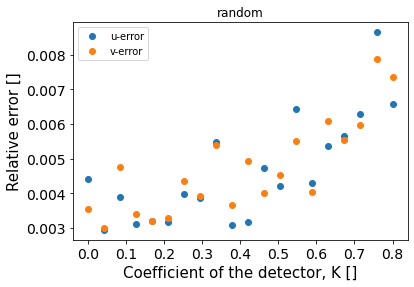

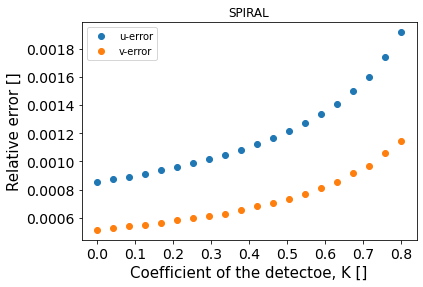

[-17.44080166872575, -69.41067339285382, 1285.3340404380174]


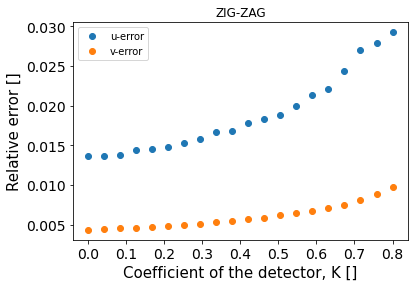

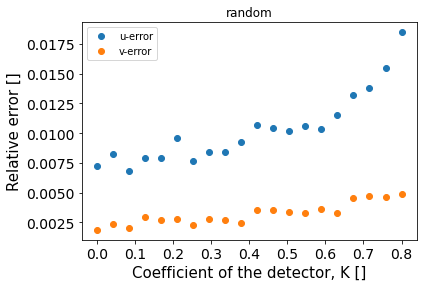

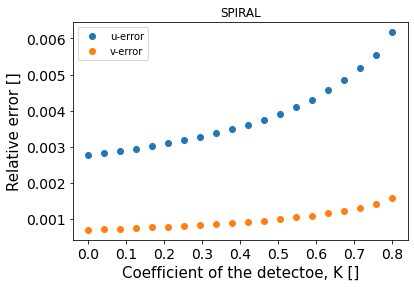

[2.603074778483162, -37.611393598636155, 1034.0183462533357]


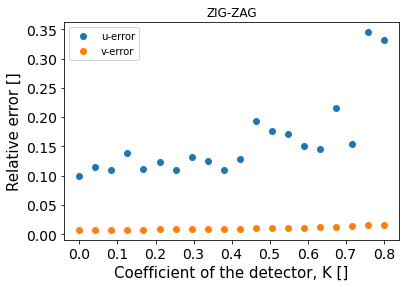

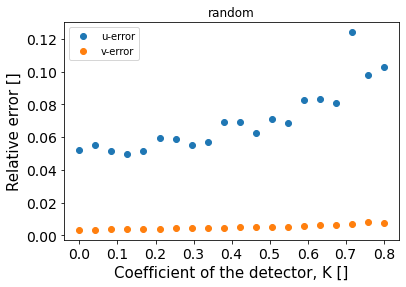

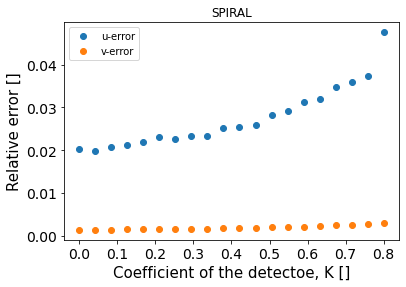

[-1.7464938413880802, -9.530361075783741, 1024.2078176186778]


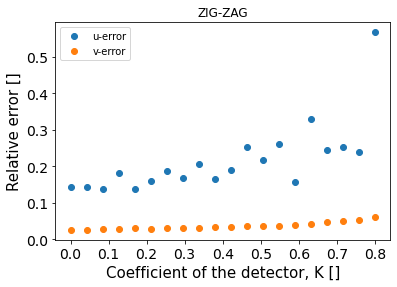

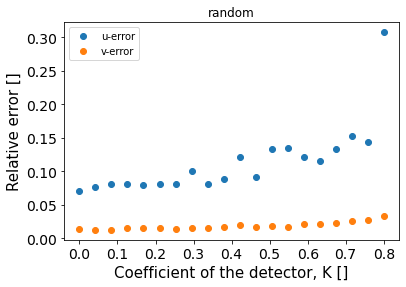

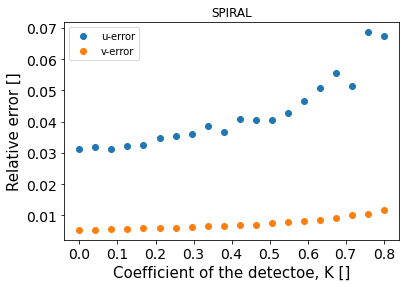

[-13.903616924175001, 57.533616149605166, 1223.873083671113]


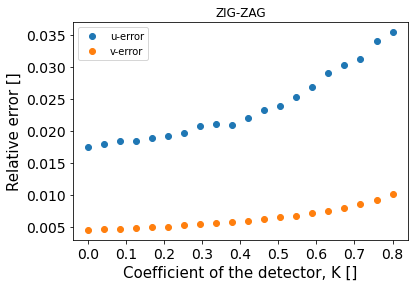

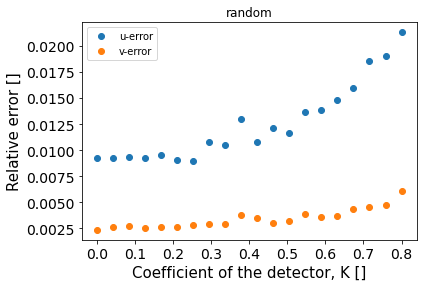

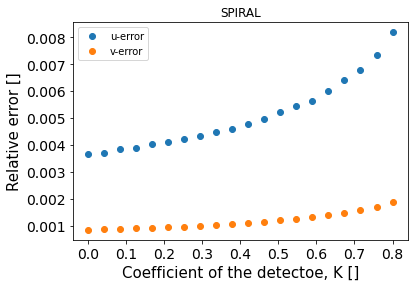

[-9.067364181808957, 72.97215234174648, 1408.4920111695458]


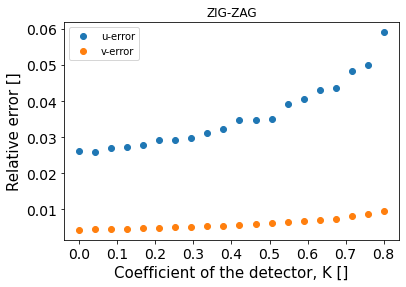

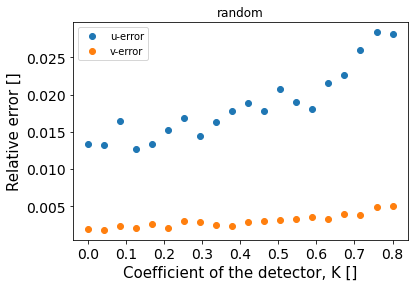

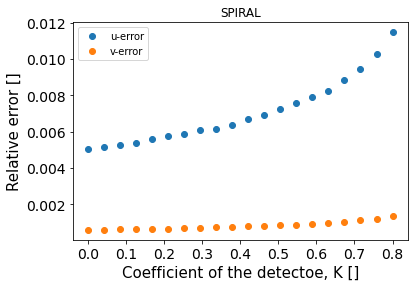

[45.97713202717703, -74.0461529768344, 1274.7043359949512]


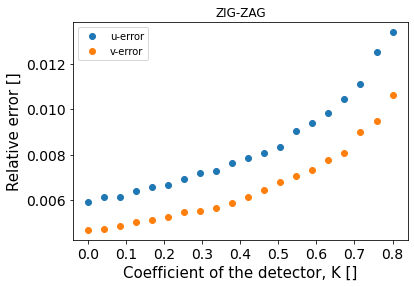

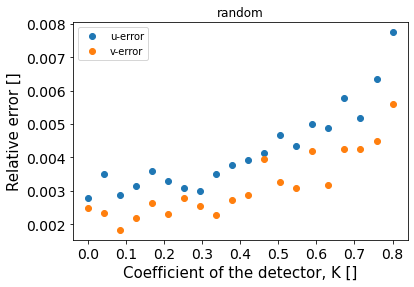

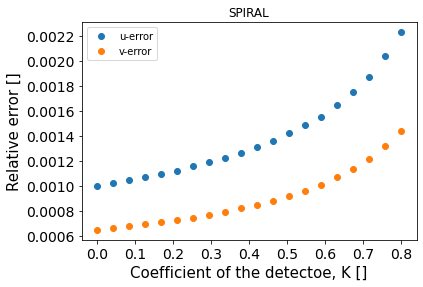

[27.662887775305936, -52.40034957367375, 1442.25688120012]


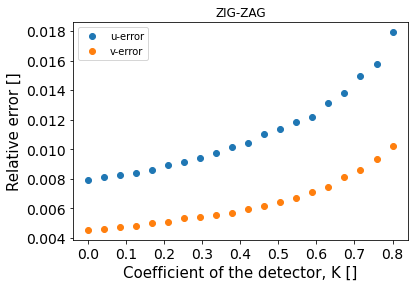

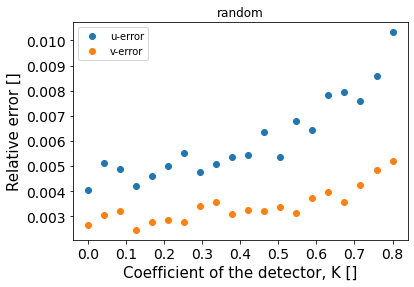

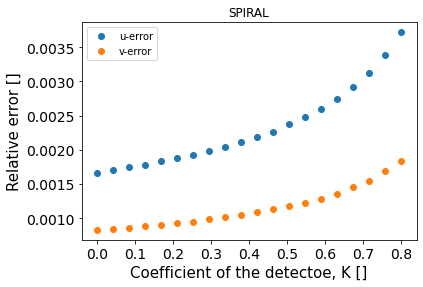

[56.17694880084354, 15.803031735647089, 1422.9184837574944]


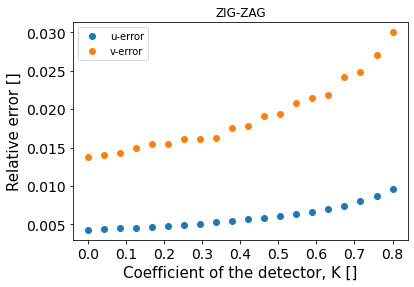

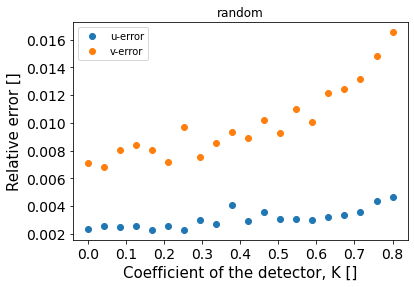

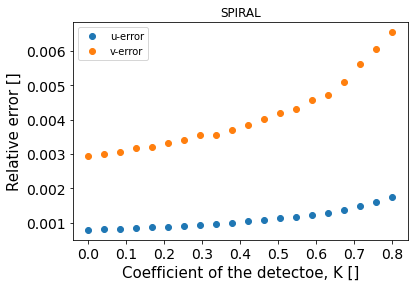

[30.7518425804127, 27.643209774994148, 1090.7700494532799]


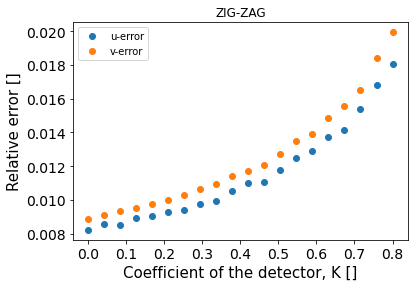

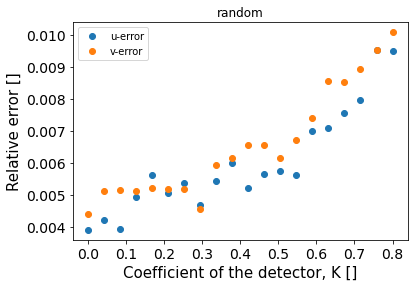

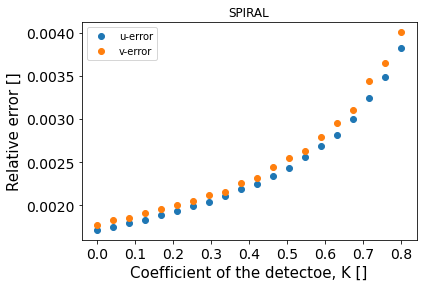

[36.369181288453035, 69.59236800772202, 1419.256613382881]


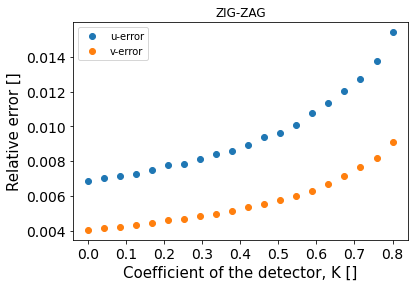

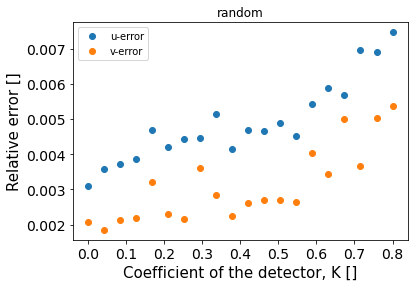

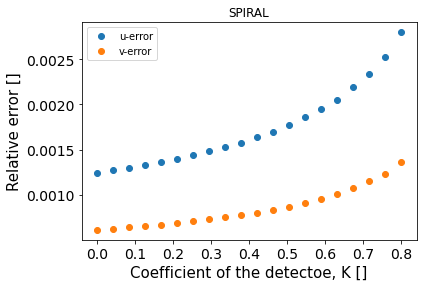

[99.20890892768423, -86.63943467998183, 1304.40222221156]


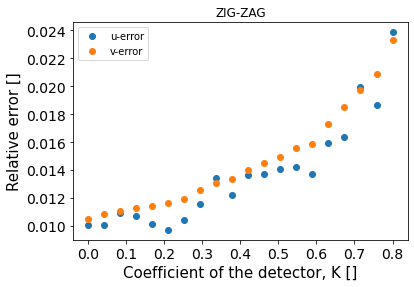

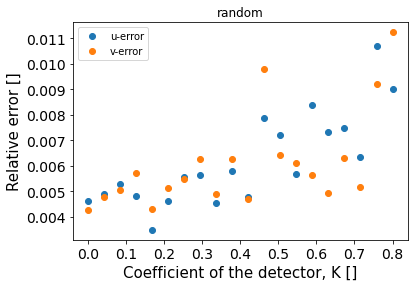

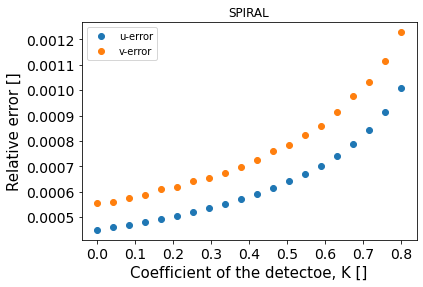

[63.31493682765672, -45.60085207889426, 1482.017954941381]


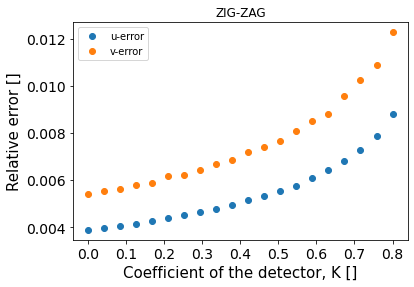

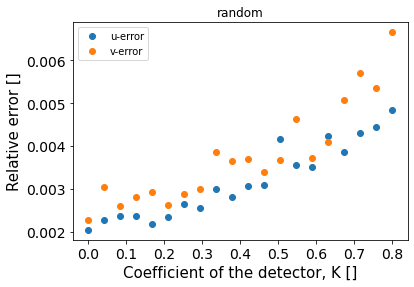

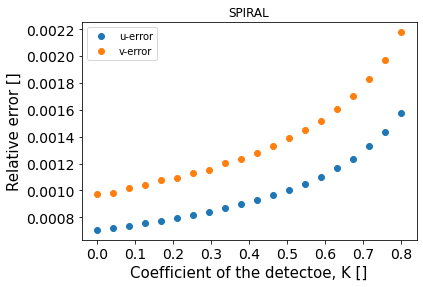

[70.49226616498163, -4.372991486896796, 1176.2574640462924]


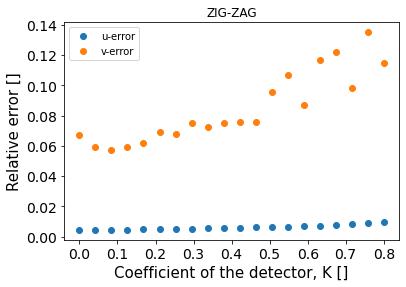

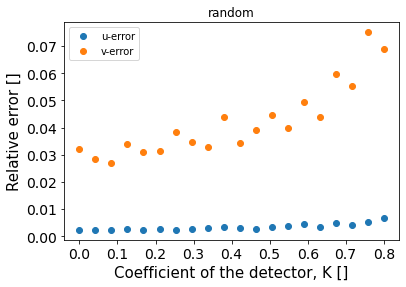

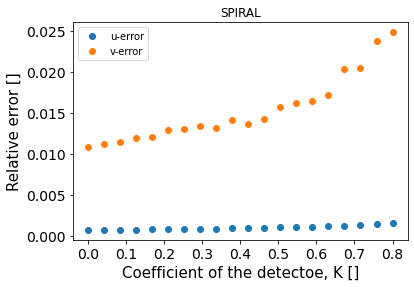

[82.69344013169045, 28.75071200699642, 1216.2317401007895]


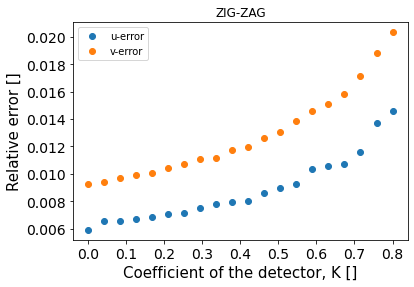

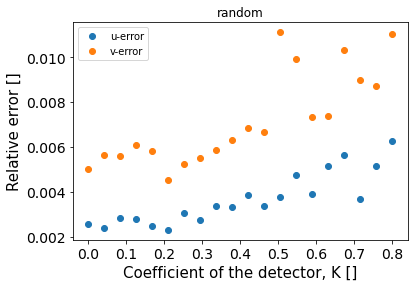

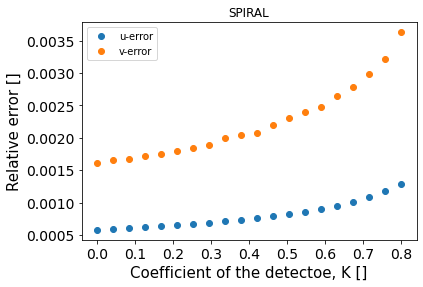

[65.2397586778966, 64.36744035784191, 1363.236450423961]


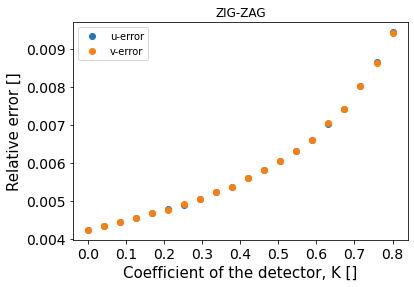

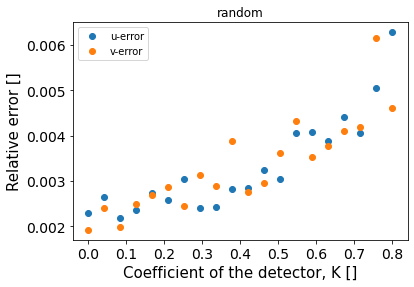

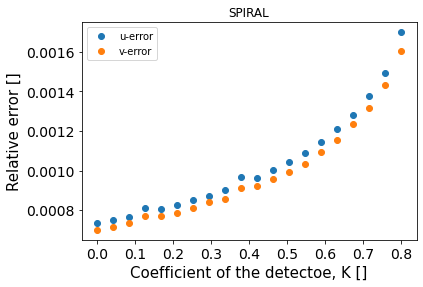

In [39]:
def loopOverGrid(radiation, detector):
    A_min, A_max = radiation["A_min"], radiation["A_max"]; detector['grid'] = 5
    x_max, y_max, grid = detector["x_max"], detector["y_max"], detector["grid"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    print(square_x)
    for x in xs:
        for y in ys:
            testSource = point_source(x + square_x/2, y + square_y/2, A_min, A_max, x - square_x/2, y - square_y/2)
            print(testSource)
            compK(radiation, detector, testSource, [])
            # input('press enter')

loopOverGrid(radiation, detector0)

# Field measurements

## Main code

In [40]:
# Preperation for when we will test the code in a practical example
# for this we will use the ZIG-ZAG method

# SHARED PARAMETERS (USED IN BOTH ZIG-ZAG AND RANDOM FLYOVER)
A_min = 1e3; A_max = 1.5e3 # borders between which the activity of the source is randomly selected 
A_b = 5e-5 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 100 # Size of the area of flyover in positive x direction in m (the whole grid extends also in the negative direction the same amount)
y_max = 100 # Size of the area of flyover in positive y direction in m (the whole grid extends also in the negative direction the same amount)
dt = 10 # the pause on each point od the grid in s
noise = [5, 5] # list that contains the standard deviation of the x and y coordinates in in m
# K = 0.8 # constant between 0 and 1 which contains the information on the quality of the detector, a better detector has a smaller constante 
        # then then an inferior detector
# F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq


# ZIG_ZAG PARAMETERS
grid = 4 # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the number of 
         # radioactive decays. Grid is the number of these areas in x direction and y direction. It must be an INTEGER!

# We have to manually fill this dictionary
# {"m_dose": HDs, "dm_dose": dHDs, "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "hotspot": maxI_range, "square_x": square_x, "square_y": square_y, "x_max": x_max, "y_max": y_max}

radiation = {'A_min': A_min, 'A_max': A_max, 'A_b': A_b, 'dose_factor': F}
detector = {"h": h, "dt": dt, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi, "spiral_grid": s_grid} # the detector constant tells us the quality of the detector

def field_flyover(radiation, detector, source=[], noise=[]):
    
    A_b = radiation['A_b']
    h = detector['h']; dt = detector['dt']; x_max = detector['x_max']; y_max = detector['y_max']; N_grid = detector['grid']

    square_x = (2*x_max)/N_grid; square_y = (2*y_max)/N_grid

    grid_x, grid_y = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    HDs = np.zeros((int(N_grid), int(N_grid))); dHDs = np.zeros((int(N_grid), int(N_grid)))

    n, m = N_grid - 1, 0
    y = -y_max + square_y/2
    i = 1
    for x in xs:
        while abs(y) <= y_max:

            HDs[n, m] = input("Enter HD for" + " (" + str(x) + ", " + str(y) + "):")
            dHDs[n, m] = input("Enter dHD for" + " (" + str(x) + ", " + str(y) + "):")
            
            grid_x[n, m] = x; grid_y[n, m] = y
            y += (square_y)*i
            n -= 1*i
        n += 1*i; i = i * (-1); y += (square_y)*i; m += 1
    
    i_max, j_max = unravel_index(HDs.argmax(), HDs.shape)
    x_c, y_c = grid_x[i_max, j_max], grid_y[i_max, j_max]
    maxI_range = {"xrange": (x_c - square_x/2, x_c + square_x/2), "yrange": (y_c - square_x/2, y_c + square_x/2)}

    return {"m_dose": HDs, "dm_dose": dHDs, "source": [], "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "hotspot": maxI_range, "square_x": square_x, "square_y": square_y, "x_max": x_max, "y_max": y_max}

# measurement = field_flyover(radiation, detector)



In [41]:
# combines the detector flyover and the location detection
# def field_combination(radiation, detector, noise=[]):
#     h = detector['h']; K = detector['detector_constant']; dt = detector['dt']
#     F = radiation['dose_factor']

#     measurement = field_flyover(radiation, detector)
#     sourceCF, stDev = locationCF(measurement, detector, noise)[0], locationCF(measurement, detector, noise)[1]

#     alpha = sourceCF[2]; rel_alpha = 1/(sourceCF[2]/stDev[2])
#     A0 = (alpha)/(F*(1-K)*dt*h**2)
#     dA0 = rel_alpha*A0

#     return {'measurement': measurement, 'sourceCF': sourceCF, "sourceCF_stDev": stDev, "A0": [A0, dA0]}

data = combination(radiation, detector, field_flyover, locationCF)


ValueError: could not convert string to float: ''

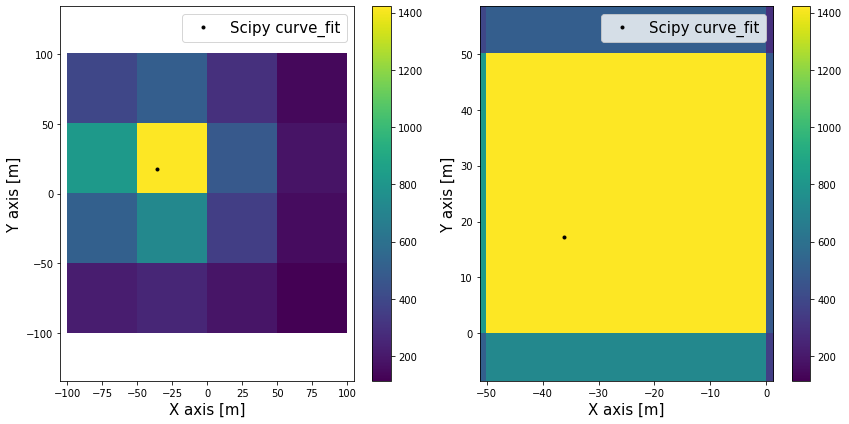

In [ ]:
visualize(data)

### Subsidary code for npyscreen

In [ ]:
def npyscreen_pars(radiation, detector, source=[], noise=[]):   
    A_b = radiation['A_b']
    h = detector['h']; dt = detector['dt']; x_max = detector['x_max']; y_max = detector['y_max']; N_grid = detector['grid']

    square_x = (2*x_max)/N_grid; square_y = (2*y_max)/N_grid

    grid_x, grid_y = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    HDs = np.zeros((int(N_grid), int(N_grid))); dHDs = np.zeros((int(N_grid), int(N_grid)))

    return {"square_x": square_x, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "xs": xs, "HDs": HDs, "dHDs": dHDs}


## Tests

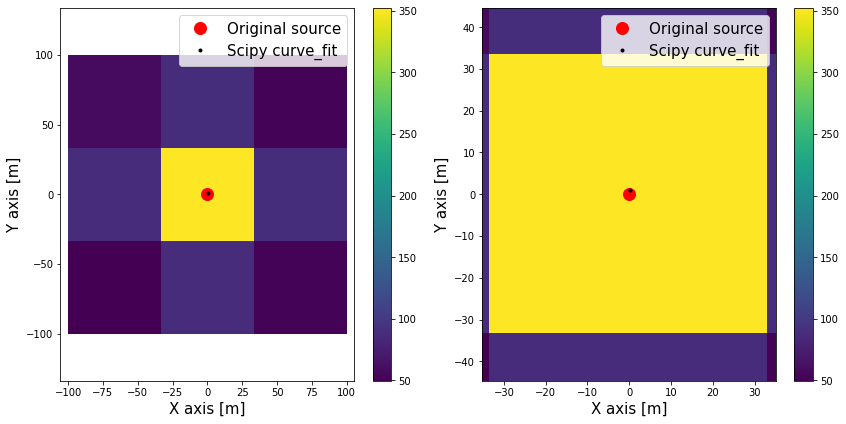

NameError: name 'field_combination' is not defined

In [ ]:
# SHARED PARAMETERS (USED IN BOTH ZIG-ZAG AND RANDOM FLYOVER)
A_min = 1e3; A_max = 1.5e3 # borders between which the activity of the source is randomly selected 
A_b = 5e-5 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 100 # Size of the area of flyover in positive x direction in m (the whole grid extends also in the negative direction the same amount)
y_max = 100 # Size of the area of flyover in positive y direction in m (the whole grid extends also in the negative direction the same amount)
dt = 10 # the pause on each point od the grid in s
noise = [5, 5] # list that contains the standard deviation of the x and y coordinates in in m
# K = 0.8 # constant between 0 and 1 which contains the information on the quality of the detector, a better detector has a smaller constante 
        # then then an inferior detector
# F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq


# ZIG_ZAG PARAMETERS
grid = 3 # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the number of 
         # radioactive decays. Grid is the number of these areas in x direction and y direction. It must be an INTEGER!

# We have to manually fill this dictionary
# {"m_dose": HDs, "dm_dose": dHDs, "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "hotspot": maxI_range, "square_x": square_x, "square_y": square_y, "x_max": x_max, "y_max": y_max}

radiation = {'A_min': A_min, 'A_max': A_max, 'A_b': A_b, 'dose_factor': F}
detector = {"h": h, "dt": dt, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K, "n_points": n_points, "max_phi": max_phi, "spiral_grid": s_grid} # the detector constant tells us the quality of the detector

# Simulated data
source00A = [0, 0, (A_min + A_max)/2]
sim_data = combination(radiation, detector, flyover, locationCF, source00A, [])
visualize(sim_data)

# Measured data
field_measurement = flyover(radiation, detector, source00A)
# print(field_measurement)
field_data = field_combination(radiation, detector, field_measurement)
visualize(field_data)

# Also location with LM method, only now using the curve_fit scipy.optimize function 
# def locationCF(measurement, detector, noise = []):
#     HDs, dHDs, grid_x, grid_y, hotspot = measurement['m_dose'], measurement['dm_dose'], measurement['grid_x'], measurement['grid_y'], measurement["hotspot"] # in example Z, here Is
#     grid_x_noise = measurement['grid_x_noise']; grid_y_noise = measurement['grid_y_noise']
#     h = detector["h"]

#     x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]

#     if len(noise) == 0:
#         XY = np.vstack((grid_x.ravel(), grid_y.ravel()))
#     else:
#         XY = np.vstack((grid_x_noise.ravel(), grid_y_noise.ravel()))
        
#     source0 = [random.uniform(x_0, x_1), random.uniform(y_0, y_1), 1]
    
#     def dose(x, y, u, v, alpha):
#         return alpha / ((x - u)**2 + (y - v)**2 + h**2)

#     def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
#         x, y = M
#         arr = np.zeros(x.shape)
#         for i in range(len(args)//3):
#             arr += dose(x, y, *args[i*3:i*3+3])
#         return arr

#     popt, pcov = curve_fit(__dose, XY, HDs.ravel(), source0, sigma = dHDs.ravel(), absolute_sigma = True, method="lm")
#     perr = np.sqrt(np.diag(pcov))
    

#     MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

#     return popt, perr, MyDict

# print(locationCF(field_measurement, detector))


# Tutorials

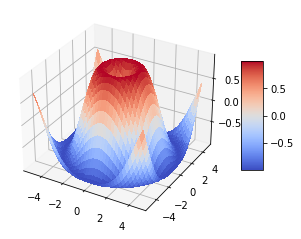

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

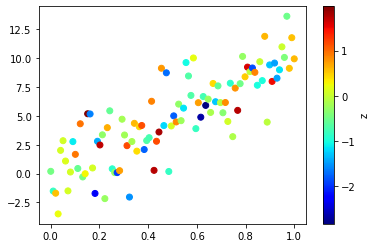

In [ ]:

x = np.linspace(0,1,100)
y = np.linspace(0,10,100) + np.random.normal(0,2,100)
z = np.random.normal(0,1,100)

#set the "c" kwarg to the array of values the colors are based on
plt.scatter(x,y,c=z,cmap='jet')
plt.colorbar(label='z')

print(x, "\n", y, "\n", z)

In [ ]:
import statistics

MyList = [1, 2, 3, 4, 5, 6, 1000]

print("Average:", sum(MyList)/len(MyList))
print("Median:", statistics.median(MyList))



Average: 145.85714285714286
Median: 4
